# 投球タイプ分類器（Pitch Identification Model）

本プロジェクトは、pybaseballライブラリを用いてMLBのStatcastデータを取得し、投球の物理的な特徴量（球速、回転、変化量など）からその球種（pitch_type）を分類する機械学習モデルを構築します。


## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・評価
7. 結果の分析・Error Analysis


## 0. ライブラリ・データ読み込み

まず初めに使用するライブラリを読み込みます。


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from pybaseball import statcast
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import warnings

# 日本語フォントの設定（文字化け防止）

# OSに応じて日本語フォントを設定
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'Hiragino Sans'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Yu Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'Noto Sans CJK JP'

# 負の符号が正しく表示されるように設定
plt.rcParams['axes.unicode_minus'] = False

# データ取得ライブラリ

# 機械学習モデル

# 警告非表示
warnings.filterwarnings('ignore')


次にpybaseball.statcast()を用いて、特定の期間の投球データを取得します。

注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストすることを推奨します。


In [93]:
# 例：2023年シーズンのデータを取得
# (注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストする)

# train.csvとtest.csvが既に存在する場合は読み込む、存在しない場合はデータを取得して作成
import os

if os.path.exists('train.csv') and os.path.exists('test.csv'):
    print("train.csvとtest.csvが既に存在します。読み込みます...")
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    print(f"train.csv: {train_data.shape}")
    print(f"test.csv: {test_data.shape}")
    # 後続のセルで使用するため、data変数も作成（train_dataとtest_dataを結合）
    data = pd.concat([train_data, test_data], ignore_index=True)
    print(f"結合後のデータ: {data.shape}")
    print("データを読み込みました。")
else:
    print("train.csvとtest.csvが存在しません。データを取得して作成します...")
    print("Fetching Statcast data...")
    data = statcast(start_dt='2023-04-01', end_dt='2023-10-01')
    print("Data fetched.")
    print(f"Data shape: {data.shape}")
    
    # 前処理
    print("\n前処理を開始します...")
    
    # データのコピーを作成
    df = data.copy()
    
    # p_throwsのエンコーディング (Label Encoding: R=0, L=1)
    if 'p_throws' in df.columns:
        print("p_throws列が見つかりました。エンコーディングを行います (R=0, L=1)。")
        df['p_throws'] = df['p_throws'].map({'R': 0, 'L': 1})
        # マッピングできなかった値（もしあれば）を確認
        if df['p_throws'].isnull().sum() > 0:
            print(f"警告: p_throwsにR/L以外の値が含まれています。欠損値数: {df['p_throws'].isnull().sum()}")
            df = df.dropna(subset=['p_throws'])
    else:
        print("警告: p_throws列がデータに存在しません。")

    
    # 必要な特徴量を選択（存在する特徴量のみ）
    feature_cols = ['release_speed', 'release_spin_rate', 'spin_axis', 
                    'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'p_throws']
    feature_cols = [feat for feat in feature_cols if feat in df.columns]
    
    if len(feature_cols) == 0:
        raise ValueError("必要な特徴量がデータに存在しません。")
    
    print(f"使用する特徴量: {feature_cols}")
    
    # 欠損値の処理：欠損が多い行を削除
    print(f"前処理前のデータ数: {len(df)}")
    if 'pitch_type' in df.columns:
        df = df.dropna(subset=feature_cols + ['pitch_type'])
    else:
        raise ValueError("'pitch_type'列がデータに存在しません。")
    print(f"前処理後のデータ数: {len(df)}")
    
    # 投球数が少ない球種を「Others」にまとめる
    pitch_counts = df['pitch_type'].value_counts()
    min_pitches = 100
    rare_pitches = pitch_counts[pitch_counts < min_pitches].index.tolist()
    if len(rare_pitches) > 0:
        df['pitch_type'] = df['pitch_type'].replace(rare_pitches, 'Others')
        print(f"投球数が{min_pitches}未満の球種を「Others」にまとめました: {rare_pitches}")
    
    # 特徴量とターゲットを含むデータフレームを作成
    df_processed = df[feature_cols + ['pitch_type']].copy()
    
    # train_test_splitでデータを分割
    from sklearn.model_selection import train_test_split
    
    train_data, test_data = train_test_split(
        df_processed, 
        test_size=0.3, 
        random_state=42, 
        stratify=df_processed['pitch_type']
    )
    
    # CSVファイルとして保存
    train_data.to_csv('train.csv', index=False)
    test_data.to_csv('test.csv', index=False)
    
    print("\ntrain.csvとtest.csvを作成しました。")
    print(f"train.csv: {train_data.shape}")
    print(f"test.csv: {test_data.shape}")
    # 後続のセルで使用するため、data変数も作成（train_dataとtest_dataを結合）
    data = pd.concat([train_data, test_data], ignore_index=True)
    print(f"結合後のデータ: {data.shape}")
    print("処理が完了しました。")


train.csvとtest.csvが既に存在します。読み込みます...
train.csv: (495454, 9)
test.csv: (212338, 9)
結合後のデータ: (707792, 9)
データを読み込みました。


## 1. データの概観・分析・前処理

### 1.1 データの概観

データのサイズを確認します。


In [94]:
print(f'データ数は{data.shape[0]}、変数は{data.shape[1]}種類です。')


データ数は707792、変数は9種類です。


In [95]:
# データの最初の数行を確認
data.head(10)


,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,release_pos_x,release_pos_z,p_throws,pitch_type
0,79.0,2741,95,0.87,0.11,-2.79,4.02,0,SL
1,93.7,2326,115,1.22,0.93,3.37,5.36,1,FF
2,92.0,2250,214,-1.50,1.07,-1.56,5.49,0,SI
3,94.5,1877,149,1.14,1.25,0.91,6.18,1,SI
4,93.6,2250,214,-0.75,1.39,-2.17,5.54,0,FF
5,85.4,2900,74,0.80,0.58,-1.96,5.32,0,ST
6,95.3,2346,216,-0.62,1.41,-2.32,5.74,0,FF
7,84.9,1578,112,1.21,-0.16,1.86,5.60,1,CH
8,78.8,2618,278,-1.18,0.33,1.47,6.07,1,SV
9,89.9,2496,174,-0.13,1.62,1.50,6.02,1,FF


In [96]:
# 変数名の一覧を確認
data.columns.tolist()


['release_speed',
 'release_spin_rate',
 'spin_axis',
 'pfx_x',
 'pfx_z',
 'release_pos_x',
 'release_pos_z',
 'p_throws',
 'pitch_type']

### 1.2 データの分析（EDA）

探索的データ分析（EDA）を行います。まず、必要な特徴量とターゲットが存在することを確認します。


In [97]:
# 必要な特徴量の確認
required_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                     'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']

# 存在する特徴量を確認
available_features = [feat for feat in required_features if feat in data.columns]
missing_features = [feat for feat in required_features if feat not in data.columns]

print("利用可能な特徴量:", available_features)
print("欠損している特徴量:", missing_features)

# 利用可能な特徴量のみを使用
if len(missing_features) > 0:
    print(f"\n警告: 以下の特徴量がデータに存在しません: {missing_features}")
    print("利用可能な特徴量のみを使用します。")


利用可能な特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']
欠損している特徴量: []


In [98]:
# 欠損値の確認（利用可能な特徴量のみ）
print("欠損値の確認:")
if len(available_features) > 0:
    print(data[available_features].isnull().sum())
else:
    print("利用可能な特徴量がありません。")


欠損値の確認:
release_speed        0
release_spin_rate    0
spin_axis            0
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_z        0
pitch_type           0
dtype: int64


In [99]:
# ターゲット（pitch_type）の分析
if 'pitch_type' in data.columns:
    print("球種の内訳:")
    print(data['pitch_type'].value_counts())
    print("\n球種の割合:")
    print(data['pitch_type'].value_counts(normalize=True))
else:
    print("エラー: 'pitch_type'列がデータに存在しません。")


球種の内訳:
pitch_type
FF        227326
SL        113741
SI        109403
CH         76883
FC         55985
CU         46914
ST         41351
FS         15864
KC         14699
SV          2810
FA          1113
FO           766
EP           557
KN           192
Others       188
Name: count, dtype: int64

球種の割合:
pitch_type
FF        0.321176
SL        0.160698
SI        0.154569
CH        0.108624
FC        0.079098
CU        0.066282
ST        0.058423
FS        0.022413
KC        0.020767
SV        0.003970
FA        0.001572
FO        0.001082
EP        0.000787
KN        0.000271
Others    0.000266
Name: proportion, dtype: float64


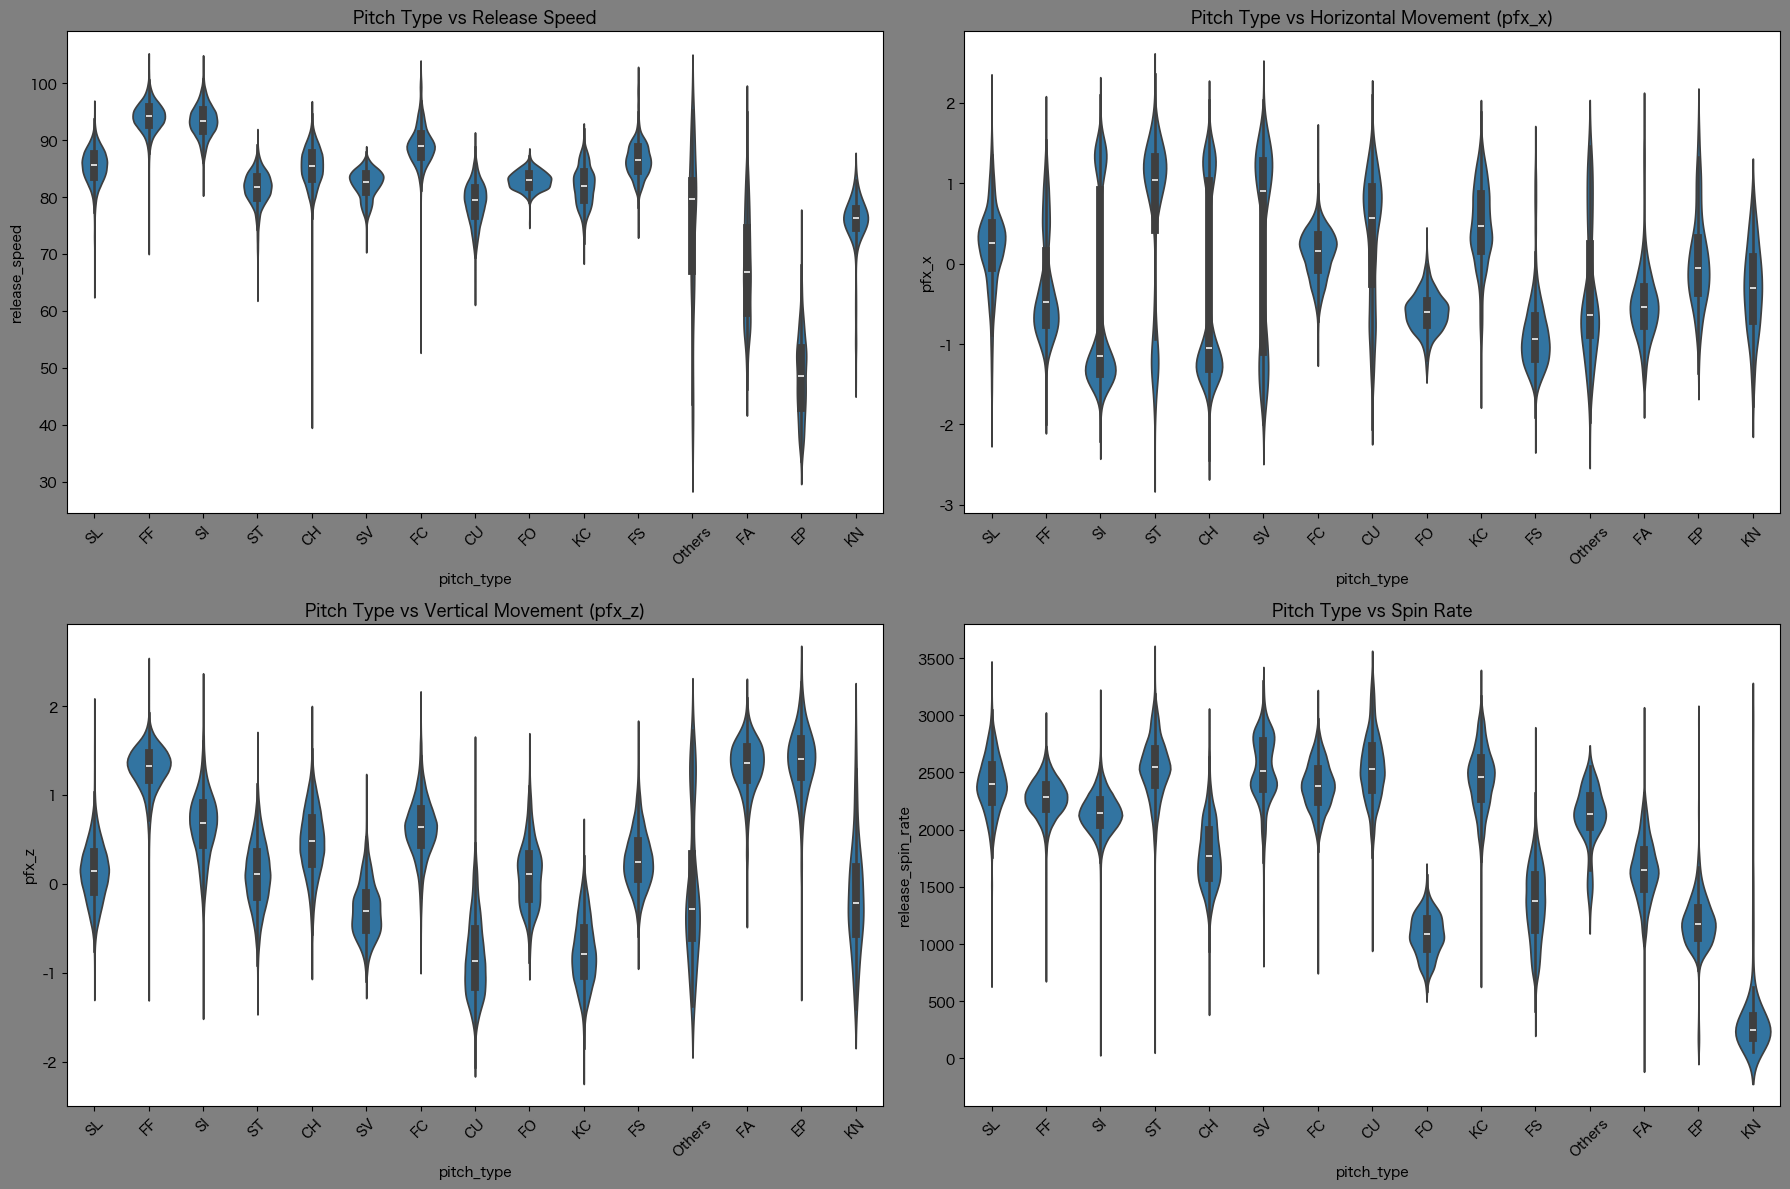

In [100]:
# 球種ごとの分布を可視化（バイオリン図）
# 利用可能な特徴量のみを使用
plot_features = []
if 'release_speed' in data.columns:
    plot_features.append(('release_speed', 'Release Speed'))
if 'pfx_x' in data.columns:
    plot_features.append(('pfx_x', 'Horizontal Movement (pfx_x)'))
if 'pfx_z' in data.columns:
    plot_features.append(('pfx_z', 'Vertical Movement (pfx_z)'))
if 'release_spin_rate' in data.columns:
    plot_features.append(('release_spin_rate', 'Spin Rate'))

if len(plot_features) > 0 and 'pitch_type' in data.columns:
    # データのコピーを作成してインデックスをリセット（重複インデックスの問題を回避）
    plot_data = data[['pitch_type'] + [feat for feat, _ in plot_features]].copy().reset_index(drop=True)
    
    n_plots = min(len(plot_features), 4)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    f, ax = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), facecolor='gray')
    if n_rows == 1:
        ax = ax.reshape(1, -1)
    
    for idx, (feat, title) in enumerate(plot_features[:4]):
        row = idx // n_cols
        col = idx % n_cols
        sns.violinplot(x="pitch_type", y=feat, data=plot_data, ax=ax[row, col])
        ax[row, col].set_title(f'Pitch Type vs {title}')
        ax[row, col].tick_params(axis='x', rotation=45)
    
    # 余ったサブプロットを非表示
    for idx in range(n_plots, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("可視化に必要な特徴量が不足しています。")


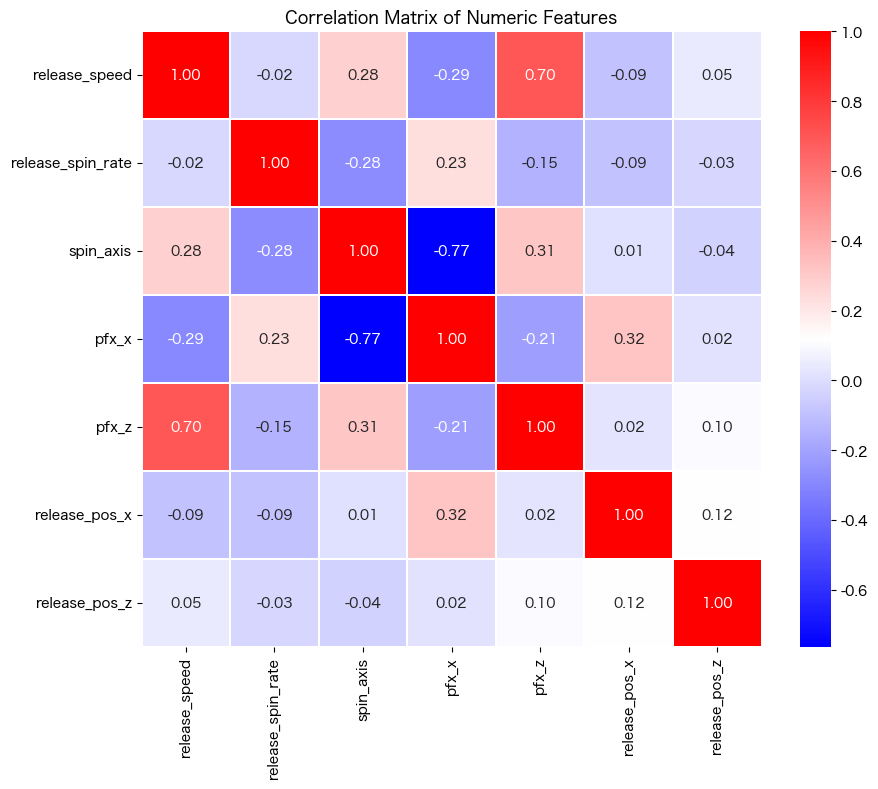

In [101]:
# 相関行列のヒートマップ
numeric_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                    'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
# 存在する特徴量のみを使用
numeric_features_available = [feat for feat in numeric_features if feat in data.columns]

if len(numeric_features_available) > 0:
    df_numeric = data[numeric_features_available].select_dtypes(include=['number'])
    if len(df_numeric.columns) > 0:
        sns.heatmap(df_numeric.corr(), annot=True, cmap='bwr', linewidths=0.2, fmt='.2f')
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title('Correlation Matrix of Numeric Features')
        plt.show()
    else:
        print("数値型の特徴量がありません。")
else:
    print("相関行列を作成するための特徴量が不足しています。")


### 1.3 データの前処理

機械学習モデルが学習できるようにデータの前処理を行います。


In [102]:
# データのコピーを作成
df = data.copy()

# 必要な特徴量を選択（存在する特徴量のみ）
feature_cols = ['release_speed', 'release_spin_rate', 'spin_axis', 
                'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'p_throws']
feature_cols = [feat for feat in feature_cols if feat in df.columns]

if len(feature_cols) == 0:
    raise ValueError("必要な特徴量がデータに存在しません。")

print(f"使用する特徴量: {feature_cols}")

# 欠損値の処理：欠損が多い行を削除
print("前処理前のデータ数:", len(df))
if 'pitch_type' in df.columns:
    df = df.dropna(subset=feature_cols + ['pitch_type'])
else:
    raise ValueError("'pitch_type'列がデータに存在しません。")
print("前処理後のデータ数:", len(df))

# 欠損値の確認
print("\n欠損値の確認:")
print(df[feature_cols + ['pitch_type']].isnull().sum())


使用する特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'p_throws']
前処理前のデータ数: 707792
前処理後のデータ数: 707792

欠損値の確認:
release_speed        0
release_spin_rate    0
spin_axis            0
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_z        0
p_throws             0
pitch_type           0
dtype: int64


In [103]:
# 投球数が少ない球種を除外または「Others」にまとめる
pitch_counts = df['pitch_type'].value_counts()
print("各球種の投球数:")
print(pitch_counts)

# 投球数が100未満の球種を「Others」にまとめる（閾値は調整可能）
min_pitches = 100
rare_pitches = pitch_counts[pitch_counts < min_pitches].index.tolist()
print(f"\n投球数が{min_pitches}未満の球種（Othersにまとめる）: {rare_pitches}")

if len(rare_pitches) > 0:
    df['pitch_type'] = df['pitch_type'].replace(rare_pitches, 'Others')
    print("\n処理後の球種の内訳:")
    print(df['pitch_type'].value_counts())


各球種の投球数:
pitch_type
FF        227326
SL        113741
SI        109403
CH         76883
FC         55985
CU         46914
ST         41351
FS         15864
KC         14699
SV          2810
FA          1113
FO           766
EP           557
KN           192
Others       188
Name: count, dtype: int64

投球数が100未満の球種（Othersにまとめる）: []


In [104]:
# 特徴量（X）とターゲット（Y）を抽出
X = df[feature_cols].values
y = df['pitch_type'].values

# ターゲットのエンコーディング（LabelEncoder）
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("特徴量の形状:", X.shape)
print("ターゲットの形状:", y_encoded.shape)
print("球種のクラス数:", len(le.classes_))
print("球種のクラス:", le.classes_)


特徴量の形状: (707792, 8)
ターゲットの形状: (707792,)
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [105]:
# データの分割（訓練データと検証データ）
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"訓練データ数: {X_train.shape[0]}")
print(f"検証データ数: {X_valid.shape[0]}")


訓練データ数: 495454
検証データ数: 212338


## 2. ベースラインモデルの構築

まずは単純なモデルで、現状のデータと前処理でどの程度の精度が出るかを確認します。


In [106]:
# ベースラインモデル：全特徴量を使用
rfc_baseline = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_baseline.fit(X_train, y_train)

print('ベースラインモデル（全特徴量）')
print('Train Score: {}'.format(round(rfc_baseline.score(X_train, y_train), 3)))
print('Valid Score: {}'.format(round(rfc_baseline.score(X_valid, y_valid), 3)))


ベースラインモデル（全特徴量）
Train Score: 0.851
Valid Score: 0.848


## 3. 特徴量エンジニアリング

ドメイン知識（野球の知識）に基づき、よりモデルの精度向上に寄与する特徴量を作成します。


In [107]:
# 特徴量エンジニアリング用のデータフレームを作成
df_fe = df.copy()

# 【4つの特徴量を追加しないバージョン】
# 1. 回転軸の変換（spin_axisは循環的な特徴量なので、sinとcosに変換）
# if 'spin_axis' in df_fe.columns:
#     df_fe['spin_axis_sin'] = np.sin(np.radians(df_fe['spin_axis']))
#     df_fe['spin_axis_cos'] = np.cos(np.radians(df_fe['spin_axis']))
#     print("spin_axis_sin と spin_axis_cos を作成しました。")
# else:
#     print("警告: 'spin_axis'が存在しないため、spin_axis_sin と spin_axis_cos をスキップします。")

# 2. 変化量の合成（水平変化量と垂直変化量から総変化量を計算）
# if 'pfx_x' in df_fe.columns and 'pfx_z' in df_fe.columns:
#     df_fe['total_movement'] = np.sqrt(df_fe['pfx_x']**2 + df_fe['pfx_z']**2)
#     print("total_movement を作成しました。")
# else:
#     print("警告: 'pfx_x' または 'pfx_z' が存在しないため、total_movement をスキップします。")

# 3. スピン効率（推定）：球速に対する回転数の比率
# if 'release_spin_rate' in df_fe.columns and 'release_speed' in df_fe.columns:
#     # ゼロ除算を防ぐため、release_speedが0の場合はNaNにする
#     df_fe['spin_per_mph'] = df_fe['release_spin_rate'] / df_fe['release_speed'].replace(0, np.nan)
#     print("spin_per_mph を作成しました。")
# else:
#     print("警告: 'release_spin_rate' または 'release_speed' が存在しないため、spin_per_mph をスキップします。")

# 新しい特徴量を確認
new_feature_list = []
# if 'spin_axis_sin' in df_fe.columns:
#     new_feature_list.append('spin_axis_sin')
# if 'spin_axis_cos' in df_fe.columns:
#     new_feature_list.append('spin_axis_cos')
# if 'total_movement' in df_fe.columns:
#     new_feature_list.append('total_movement')
# if 'spin_per_mph' in df_fe.columns:
#     new_feature_list.append('spin_per_mph')

if len(new_feature_list) > 0:
    print("\n新しく作成した特徴量:")
    print(df_fe[new_feature_list].head())
    print("\n欠損値の確認:")
    print(df_fe[new_feature_list].isnull().sum())
else:
    print("\n新しく作成された特徴量はありません。")



新しく作成された特徴量はありません。


In [108]:
# 特徴量エンジニアリング後の特徴量リスト
# 【4つの特徴量を追加しないバージョン】
# new_features = ['spin_axis_sin', 'spin_axis_cos', 'total_movement', 'spin_per_mph']
# feature_cols_fe = feature_cols + [feat for feat in new_features if feat in df_fe.columns]
feature_cols_fe = feature_cols  # 元の特徴量のみを使用

# 欠損値の処理
df_fe = df_fe.dropna(subset=feature_cols_fe + ['pitch_type'])

# 特徴量とターゲットを抽出
X_fe = df_fe[feature_cols_fe].values
y_fe = df_fe['pitch_type'].values

# ターゲットのエンコーディング（新しいLabelEncoderを作成してfit_transformを使用）
# 特徴量エンジニアリング後のデータでも同じ球種が含まれているはずですが、
# 念のため新しいLabelEncoderを使用します
le_fe = LabelEncoder()
y_fe_encoded = le_fe.fit_transform(y_fe)

# データの分割
# stratifyを使用するため、インデックスではなく配列を直接分割
X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(
    X_fe, y_fe_encoded, test_size=0.3, random_state=42, stratify=y_fe_encoded
)

print(f"特徴量エンジニアリング後の特徴量数: {len(feature_cols_fe)}")
print(f"特徴量: {feature_cols_fe}")
print(f"訓練データ数: {X_fe_train.shape[0]}")
print(f"検証データ数: {X_fe_valid.shape[0]}")
print(f"球種のクラス数: {len(le_fe.classes_)}")
print(f"球種のクラス: {le_fe.classes_}")


特徴量エンジニアリング後の特徴量数: 8
特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'p_throws']
訓練データ数: 495454
検証データ数: 212338
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [109]:
# 特徴量エンジニアリング後のベースラインモデル
rfc_fe = RandomForestClassifier(max_depth=7, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe.fit(X_fe_train, y_fe_train)

print('特徴量エンジニアリング後のベースラインモデル')
print('Train Score: {}'.format(round(rfc_fe.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(rfc_fe.score(X_fe_valid, y_fe_valid), 3)))


特徴量エンジニアリング後のベースラインモデル
Train Score: 0.811
Valid Score: 0.81


## 4. 様々なモデルの構築・調整

ベースラインモデルや特徴量エンジニアリングの結果を踏まえ、より強力なモデルを構築・調整します。


In [110]:
# XGBoostモデル
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_fe_train, y_fe_train)

print('XGBoostモデル')
print('Train Score: {}'.format(round(xgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(xgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, xgb_model.predict(X_fe_valid), average='weighted'), 3)))


XGBoostモデル
Train Score: 0.886
Valid Score: 0.88
Valid F1 Score (weighted): 0.879


In [111]:
# LightGBMモデル
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_fe_train, y_fe_train)

print('LightGBMモデル')
print('Train Score: {}'.format(round(lgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(lgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, lgb_model.predict(X_fe_valid), average='weighted'), 3)))


LightGBMモデル
Train Score: 0.761
Valid Score: 0.758
Valid F1 Score (weighted): 0.758


In [112]:
# ハイパーパラメータチューニング（GridSearchCV）- LightGBMの例
# 注意：計算時間がかかるため、パラメータの範囲を狭めています
param_grid_lgb = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

print("GridSearchCVを実行中...（時間がかかる場合があります）")
lgb_gs = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_grid_lgb,
    cv=3,  # クロスバリデーションの分割数（計算時間を考慮して3に設定）
    scoring='accuracy',
    n_jobs=-1
)
lgb_gs.fit(X_fe_train, y_fe_train)

print('Best Parameters: {}'.format(lgb_gs.best_params_))
print('CV Score: {}'.format(round(lgb_gs.best_score_, 3)))
print('Valid Score: {}'.format(round(lgb_gs.score(X_fe_valid, y_fe_valid), 3)))


GridSearchCVを実行中...（時間がかかる場合があります）
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
CV Score: 0.874
Valid Score: 0.875


## 5. モデルのアンサンブリング

複数のモデルを組み合わせて、より頑健なモデルとします


In [113]:
# 各モデルの予測確率を取得
rfc_pred_proba = rfc_fe.predict_proba(X_fe_valid)
xgb_pred_proba = xgb_model.predict_proba(X_fe_valid)
lgb_pred_proba = lgb_model.predict_proba(X_fe_valid)

# 予測確率の平均（ブレンディング）
ensemble_pred_proba = (rfc_pred_proba + xgb_pred_proba + lgb_pred_proba) / 3
ensemble_pred = ensemble_pred_proba.argmax(axis=1)

# アンサンブルモデルの評価
ensemble_accuracy = accuracy_score(y_fe_valid, ensemble_pred)
ensemble_f1 = f1_score(y_fe_valid, ensemble_pred, average='weighted')

print('アンサンブルモデル（RandomForest + XGBoost + LightGBM）')
print('Valid Accuracy: {}'.format(round(ensemble_accuracy, 3)))
print('Valid F1 Score (weighted): {}'.format(round(ensemble_f1, 3)))


アンサンブルモデル（RandomForest + XGBoost + LightGBM）
Valid Accuracy: 0.832
Valid F1 Score (weighted): 0.829


## 6. 予測の出力・評価

最終的に構築したモデルを使い、検証データに対して予測を行い、詳細な評価を行います。


In [114]:
# 最良モデル（アンサンブルモデル）の予測
best_pred = ensemble_pred

# Classification Report（適合率、再現率、F1スコア）
# 特徴量エンジニアリング後のLabelEncoderを使用
print("Classification Report:")
print(classification_report(y_fe_valid, best_pred, target_names=le_fe.classes_))


Classification Report:
              precision    recall  f1-score   support

          CH       0.84      0.91      0.87     23065
          CU       0.78      0.78      0.78     14074
          EP       0.94      0.62      0.75       167
          FA       0.76      0.69      0.73       334
          FC       0.67      0.60      0.64     16796
          FF       0.93      0.95      0.94     68198
          FO       0.77      0.12      0.20       230
          FS       0.74      0.57      0.64      4759
          KC       0.68      0.43      0.53      4410
          KN       0.86      0.52      0.65        58
      Others       0.32      0.11      0.16        56
          SI       0.89      0.87      0.88     32821
          SL       0.73      0.79      0.76     34122
          ST       0.74      0.73      0.73     12405
          SV       0.56      0.35      0.43       843

    accuracy                           0.83    212338
   macro avg       0.75      0.60      0.65    212338
wei

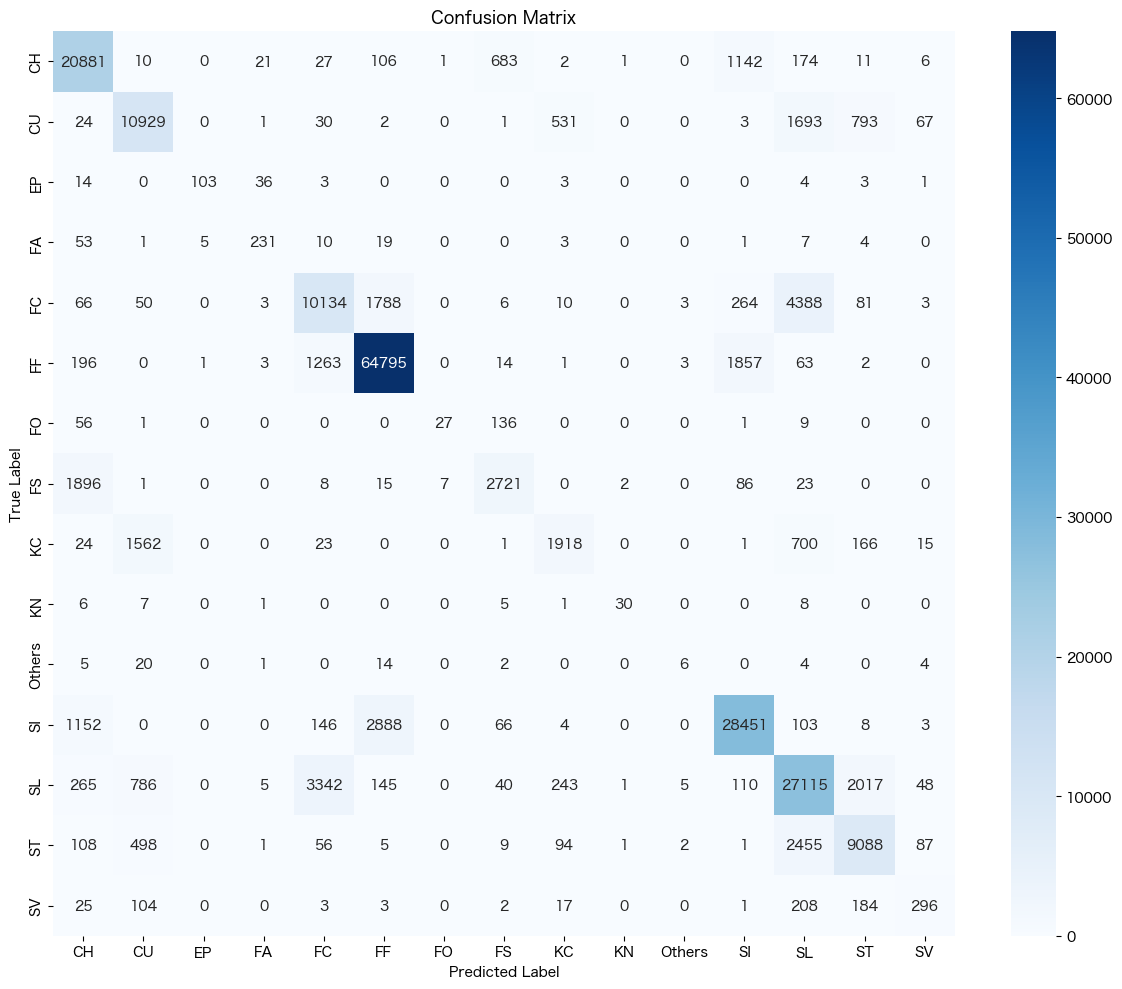

In [115]:
# 混同行列（Confusion Matrix）
cm = confusion_matrix(y_fe_valid, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_fe.classes_, yticklabels=le_fe.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


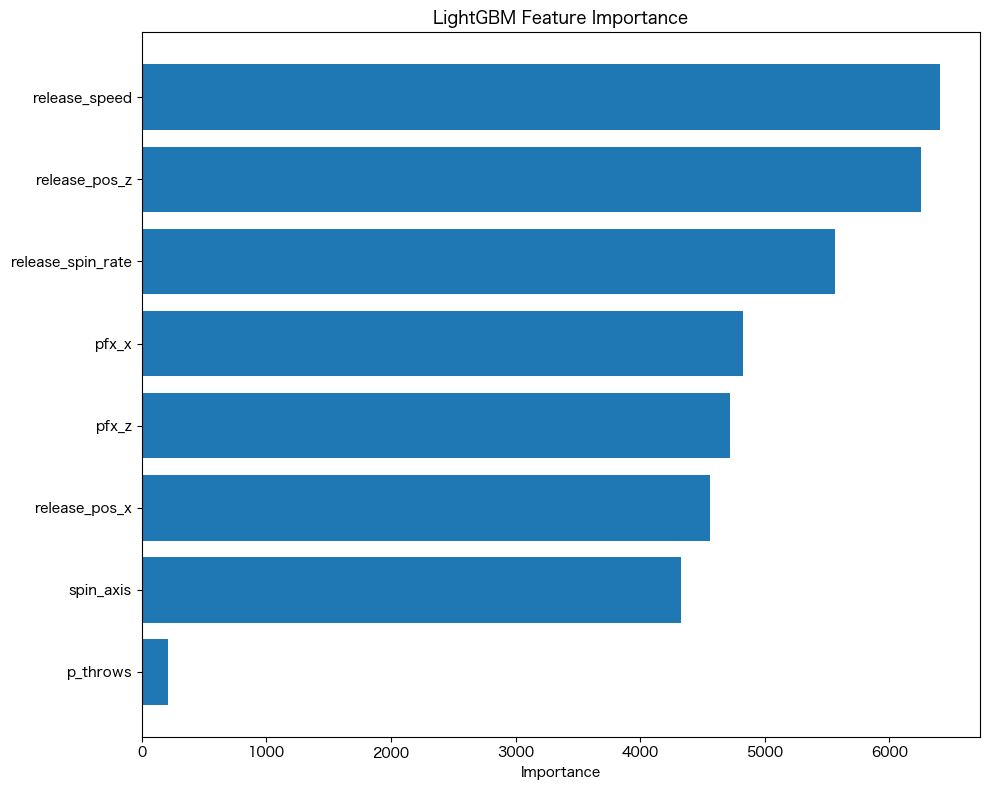


特徴量の説明:
  release_speed: リリース速度 (mph)
  release_spin_rate: リリース回転数 (rpm)
  spin_axis: 回転軸 (度)
  pfx_x: 水平方向の変化量 (インチ)
  pfx_z: 垂直方向の変化量 (インチ)
  release_pos_x: リリース位置のX座標 (フィート)
  release_pos_z: リリース位置のZ座標 (フィート)


In [116]:
# Feature Importance（特徴量重要度）の可視化 - LightGBM
# 特徴量重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'feature': feature_cols_fe,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# 上位15個の特徴量を表示
top_features = importance_df.head(15)

# プロット作成
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'], align='center')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()  # 重要度の高い順に上から表示
plt.tight_layout()
plt.show()

# 特徴量の説明
print("\n特徴量の説明:")
feature_descriptions = {
    'release_speed': 'リリース速度 (mph)',
    'release_spin_rate': 'リリース回転数 (rpm)',
    'spin_axis': '回転軸 (度)',
    'pfx_x': '水平方向の変化量 (インチ)',
    'pfx_z': '垂直方向の変化量 (インチ)',
    'release_pos_x': 'リリース位置のX座標 (フィート)',
    'release_pos_z': 'リリース位置のZ座標 (フィート)',
    'spin_axis_sin': '回転軸のsin変換',
    'spin_axis_cos': '回転軸のcos変換',
    'total_movement': '総変化量 (√(pfx_x² + pfx_z²))',
    'spin_per_mph': '速度あたりの回転数 (release_spin_rate / release_speed)'
}
for feat in feature_cols_fe:
    if feat in feature_descriptions:
        print(f"  {feat}: {feature_descriptions[feat]}")


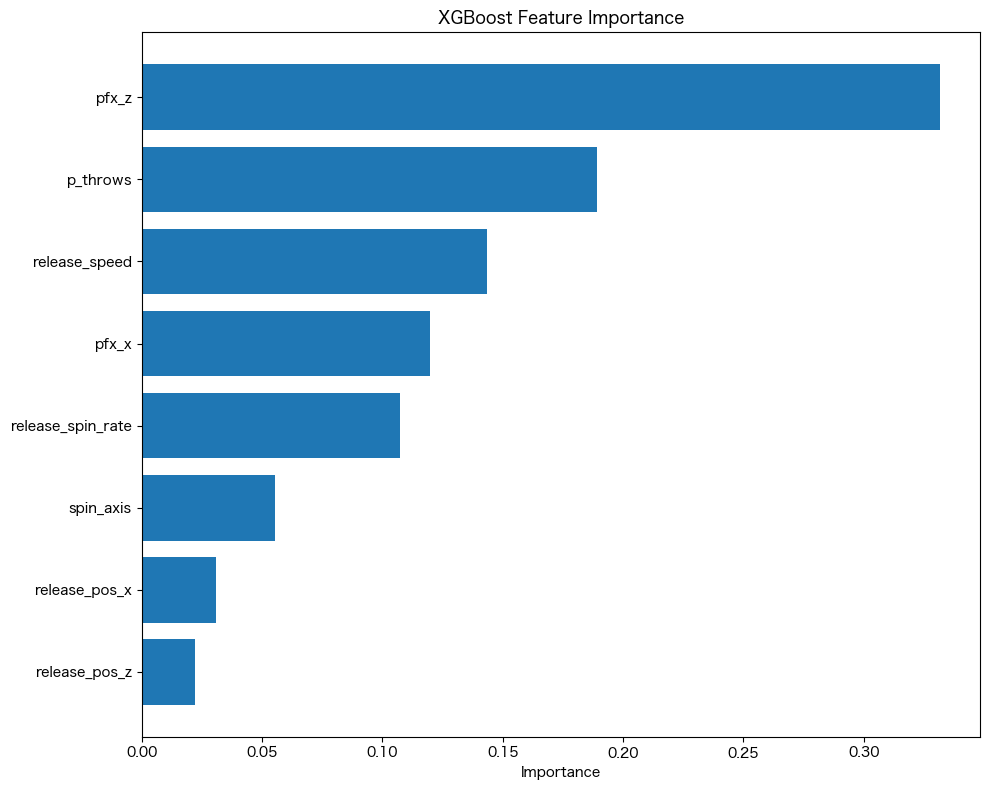

In [117]:
# Feature Importance（特徴量重要度）の可視化 - XGBoost
# 特徴量重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'feature': feature_cols_fe,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# 上位15個の特徴量を表示
top_features = importance_df.head(15)

# プロット作成
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'], align='center')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # 重要度の高い順に上から表示
plt.tight_layout()
plt.show()


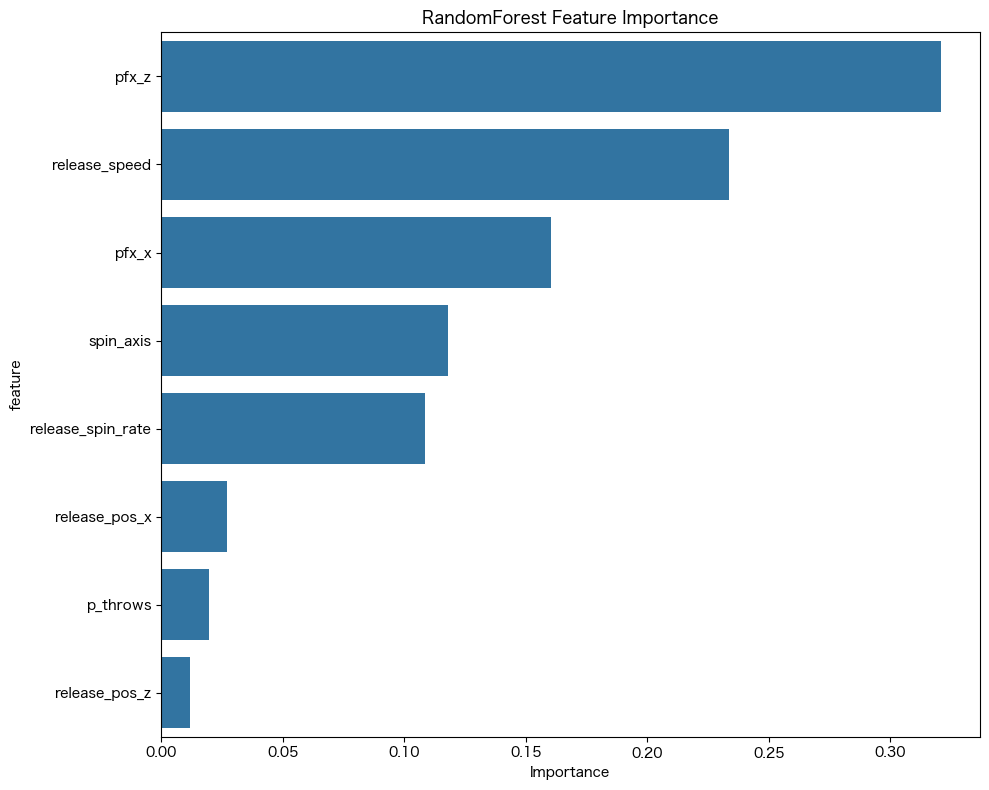

In [118]:
# RandomForestの特徴量重要度
feature_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'importance': rfc_fe.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 7. 結果の分析・Error Analysis

Kaggle流PDCAサイクルの「結果の分析・Error Analysis」フェーズです。

### 分析の目的
- なぜスコアが上がったのか？/ なぜ下がったのか？
- まだ間違えているデータはどれか？
- 次の仮説（特徴量エンジニアリング）のヒントを得る

### 分析の流れ
1. **全体を見る（Global Analysis）**: モデルの「傾向」や「癖」を掴む
2. **個別データを見る（Local Analysis）**: 失敗データから改善のヒントを得る
3. **要因を見る（Feature Analysis）**: なぜその予測をしたのか、判断の根拠を探る

### 7.1 全体を見る（Global Analysis）

まずは森全体を見て、モデルの「傾向」や「癖」を掴みます。

#### 7.1.1 混同行列の確認

「見逃し（False Negative）」が多いのか、「誤検知（False Positive）」が多いのか、特定のクラス間で迷っているのかを特定します。

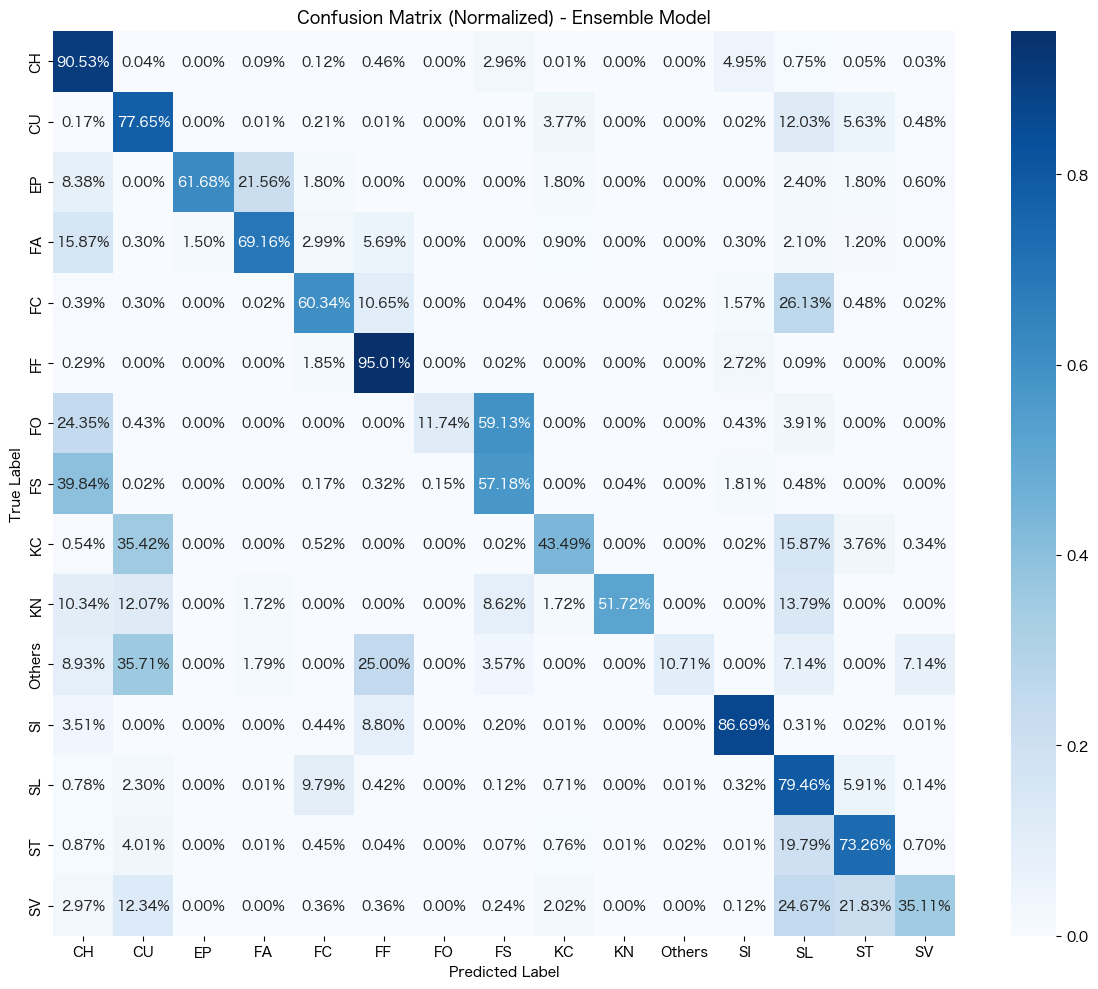


混同行列（数値）:
           CH     CU   EP   FA     FC     FF  FO    FS    KC  KN  Others  \
CH      20881     10    0   21     27    106   1   683     2   1       0   
CU         24  10929    0    1     30      2   0     1   531   0       0   
EP         14      0  103   36      3      0   0     0     3   0       0   
FA         53      1    5  231     10     19   0     0     3   0       0   
FC         66     50    0    3  10134   1788   0     6    10   0       3   
FF        196      0    1    3   1263  64795   0    14     1   0       3   
FO         56      1    0    0      0      0  27   136     0   0       0   
FS       1896      1    0    0      8     15   7  2721     0   2       0   
KC         24   1562    0    0     23      0   0     1  1918   0       0   
KN          6      7    0    1      0      0   0     5     1  30       0   
Others      5     20    0    1      0     14   0     2     0   0       6   
SI       1152      0    0    0    146   2888   0    66     4   0       0   
S

In [119]:
# 混同行列の可視化（アンサンブルモデル）
from sklearn.metrics import confusion_matrix

# 予測結果を取得
y_pred_ensemble = ensemble_pred

# 混同行列を計算
cm = confusion_matrix(y_fe_valid, y_pred_ensemble)

# クラス名を取得
class_names = le_fe.classes_

# 混同行列を正規化（パーセンテージ表示）
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 可視化
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 数値の混同行列も表示
print("\n混同行列（数値）:")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

# 各クラスの精度を計算
print("\n各クラスの精度:")
for i, class_name in enumerate(class_names):
    if cm[i, i] > 0:
        if cm[:, i].sum() > 0 and cm[i, :].sum() > 0:
            precision = cm[i, i] / cm[:, i].sum()
            recall = cm[i, i] / cm[i, :].sum()
            print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}")

#### 7.1.2 ROC曲線とAUCの確認

モデルの分類能力の総合力を図ります。多クラス分類のため、各クラスごとにOne-vs-RestでROC曲線を描画します。

##### ROC曲線とは？

**ROC曲線（Receiver Operating Characteristic Curve）**は、分類モデルの性能を評価するためのグラフです。

- **横軸（False Positive Rate, FPR）**: 偽陽性率 = 実際は「そのクラスではない」のに「そのクラス」と予測した割合
  - FPR = 偽陽性数 / (偽陽性数 + 真陰性数)
  - 「間違ってポジティブと判定した割合」

- **縦軸（True Positive Rate, TPR）**: 真陽性率 = 実際に「そのクラス」で、正しく「そのクラス」と予測した割合
  - TPR = 真陽性数 / (真陽性数 + 偽陰性数)
  - 「正しくポジティブと判定できた割合」（Recallと同じ）

##### どう読むか？

- **左上に張り付いているほど良い**: 偽陽性を抑えながら、真陽性を多く捉えられている
- **対角線（Random）**: ランダムな予測と同じ性能。AUC = 0.5
- **AUC（Area Under Curve）**: 曲線下面積。0.5（ランダム）〜1.0（完璧）の値を取る
  - AUC = 0.9以上: 優秀
  - AUC = 0.7-0.9: 良好
  - AUC = 0.5-0.7: 改善の余地あり

##### 多クラス分類での扱い

投球分類は15種類の球種を分類する多クラス分類なので、**One-vs-Rest（一対他）**方式で評価します：

- 各球種（例：FF）について、「FF vs その他すべて」という2クラス分類として扱う
- 各球種ごとにROC曲線を描画
- 全クラスの平均（Macro-average）や全体（Micro-average）のAUCも計算

クラス数: 15
予測確率の形状: (212338, 15)
バイナリ化ラベルの形状: (212338, 15)
CH: AUC = 0.993
CU: AUC = 0.988
EP: AUC = 1.000
FA: AUC = 0.993
FC: AUC = 0.969
FF: AUC = 0.993
FO: AUC = 0.999
FS: AUC = 0.991
KC: AUC = 0.987
KN: AUC = 0.999
Others: AUC = 0.930
SI: AUC = 0.990
SL: AUC = 0.968
ST: AUC = 0.987
SV: AUC = 0.992


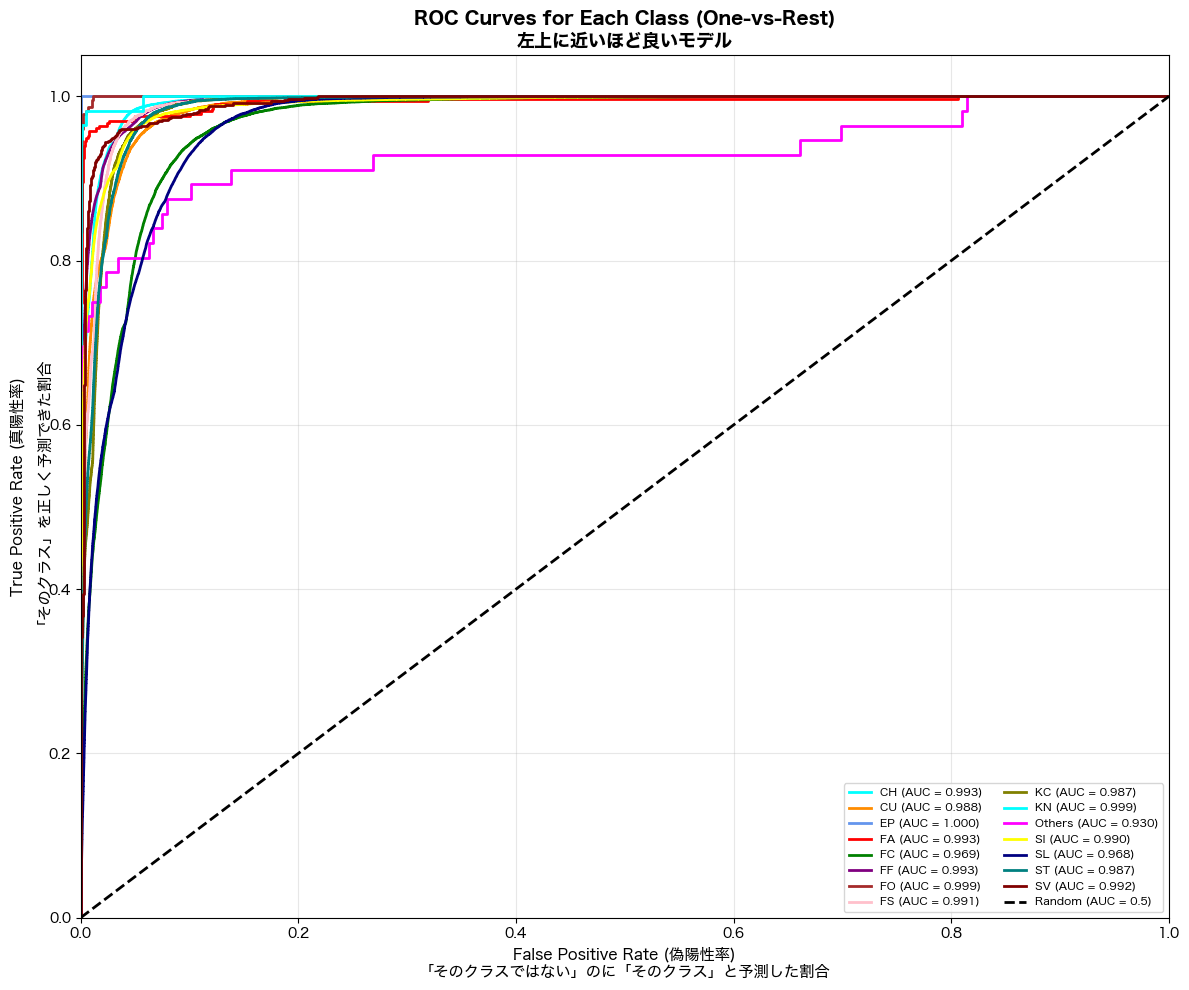


AUC値の解釈:
Macro-average AUC: 0.985
  → 各クラスのAUCを平均した値（各クラスを平等に評価）
Micro-average AUC: 0.993
  → 全サンプルを1つの問題として扱ったAUC（サンプル数の多いクラスの影響大）

評価基準:
  AUC = 0.9以上: 優秀なモデル
  AUC = 0.7-0.9: 良好なモデル
  AUC = 0.5-0.7: 改善の余地あり
  AUC = 0.5: ランダムな予測と同じ（意味なし）


In [120]:
# ============================================
# ROC曲線とAUCの計算（多クラス分類）
# ============================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# ============================================
# ステップ1: 予測確率を取得
# ============================================
# アンサンブルモデルが各クラスに対して出力した確率
# 例: [0.05, 0.80, 0.10, 0.05, ...] → 2番目のクラス（FF）が80%の確率
y_pred_proba_ensemble = ensemble_pred_proba

# ============================================
# ステップ2: ラベルをバイナリ化（One-vs-Rest方式）
# ============================================
# 多クラス分類を「各クラス vs その他すべて」の2クラス分類に変換
# 例: 正解が「FF」の場合 → [0, 1, 0, 0, ...] (FFの位置だけ1)
y_valid_binarized = label_binarize(y_fe_valid, classes=range(len(class_names)))
n_classes = len(class_names)

print(f"クラス数: {n_classes}")
print(f"予測確率の形状: {y_pred_proba_ensemble.shape}")
print(f"バイナリ化ラベルの形状: {y_valid_binarized.shape}")

# ============================================
# ステップ3: 各クラスごとにROC曲線を計算
# ============================================
fpr = dict()  # False Positive Rate（偽陽性率）を格納
tpr = dict()  # True Positive Rate（真陽性率）を格納
roc_auc = dict()  # AUC値を格納

for i in range(n_classes):
    # クラスiについて、「クラスi vs その他すべて」としてROC曲線を計算
    # y_valid_binarized[:, i]: クラスiが正解かどうか（0 or 1）
    # y_pred_proba_ensemble[:, i]: クラスiと予測した確率
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], y_pred_proba_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.3f}")

# ============================================
# ステップ4: マイクロ平均のROC曲線（全体の性能）
# ============================================
# 全クラスを1つの大きな2クラス問題として扱う
# ravel()で1次元に変換: 全サンプル×全クラスを1つの配列に
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_valid_binarized.ravel(),  # 全クラスの正解ラベルを1次元に
    y_pred_proba_ensemble.ravel()  # 全クラスの予測確率を1次元に
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ============================================
# ステップ5: 可視化
# ============================================
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 
                'olive', 'cyan', 'magenta', 'yellow', 'navy', 'teal', 'maroon'])

# 各クラスのROC曲線をプロット
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# ランダム予測の基準線（対角線）
# この線に近い = ランダムな予測と変わらない
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (偽陽性率)\n「そのクラスではない」のに「そのクラス」と予測した割合', fontsize=11)
plt.ylabel('True Positive Rate (真陽性率)\n「そのクラス」を正しく予測できた割合', fontsize=11)
plt.title('ROC Curves for Each Class (One-vs-Rest)\n左上に近いほど良いモデル', fontsize=13, fontweight='bold')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# ステップ6: 平均AUCを表示
# ============================================
# Macro-average: 各クラスのAUCを単純平均（各クラスを平等に扱う）
macro_auc = np.mean([roc_auc[i] for i in range(n_classes)])

# Micro-average: 全サンプルを1つの大きな問題として扱ったAUC
# サンプル数の多いクラスの影響を受けやすい

print("\n" + "="*60)
print("AUC値の解釈:")
print("="*60)
print(f"Macro-average AUC: {macro_auc:.3f}")
print("  → 各クラスのAUCを平均した値（各クラスを平等に評価）")
print(f"Micro-average AUC: {roc_auc['micro']:.3f}")
print("  → 全サンプルを1つの問題として扱ったAUC（サンプル数の多いクラスの影響大）")
print("\n評価基準:")
print("  AUC = 0.9以上: 優秀なモデル")
print("  AUC = 0.7-0.9: 良好なモデル")
print("  AUC = 0.5-0.7: 改善の余地あり")
print("  AUC = 0.5: ランダムな予測と同じ（意味なし）")
print("="*60)

#### 7.1.3 キャリブレーションの確認

「モデルが出す確率（自信）」と「実際の正解率」が合っているかを確認します。
例：モデルが「確率80%」と予測したデータ群は、実際に10回中8回正解しているか？
これがズレていると、スコア（LogLossなど）が悪化します。

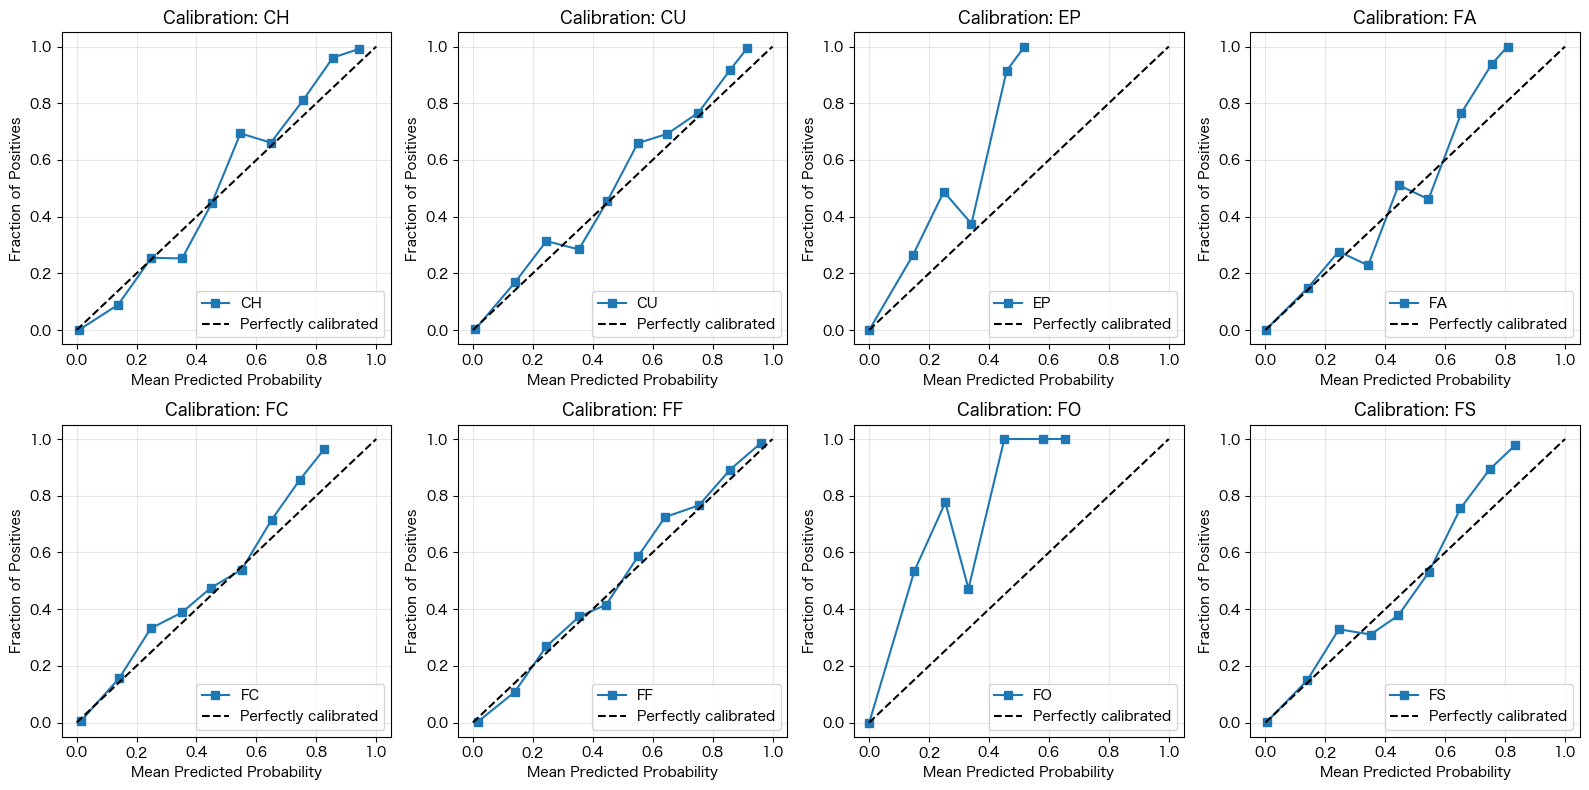

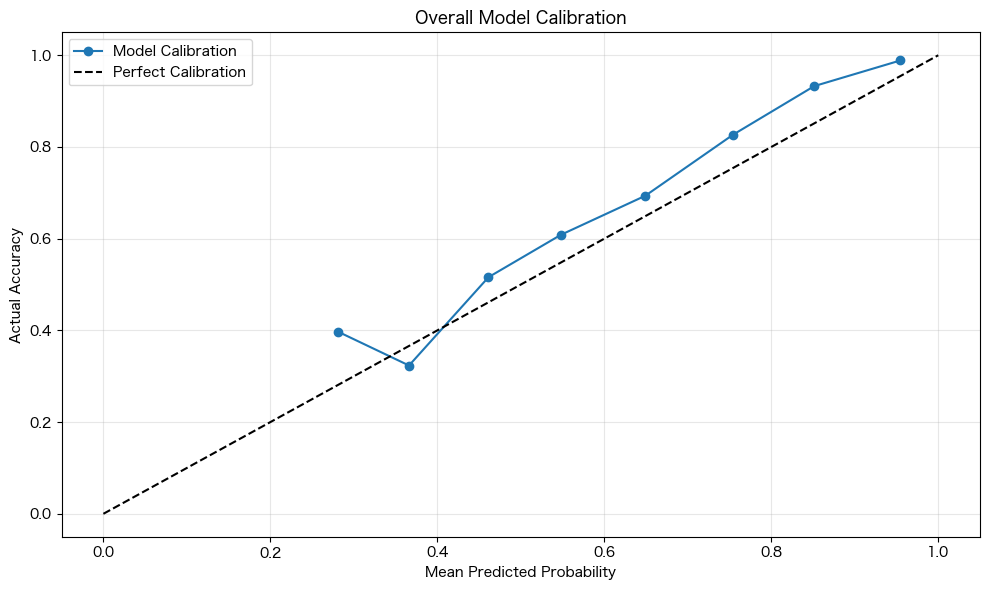

In [121]:
# キャリブレーション曲線の可視化
from sklearn.calibration import calibration_curve

# 各クラスごとにキャリブレーションを確認
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if i < len(axes):
        # そのクラスが正解かどうかのバイナリラベル
        y_true_binary = (y_fe_valid == i).astype(int)
        y_pred_proba_binary = y_pred_proba_ensemble[:, i]
        
        # キャリブレーション曲線を計算
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true_binary, y_pred_proba_binary, n_bins=10, strategy='uniform'
        )
        
        # プロット
        axes[i].plot(mean_predicted_value, fraction_of_positives, "s-", label=class_name)
        axes[i].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
        axes[i].set_xlabel('Mean Predicted Probability')
        axes[i].set_ylabel('Fraction of Positives')
        axes[i].set_title(f'Calibration: {class_name}')
        axes[i].legend(loc="lower right")
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 全体のキャリブレーション（最大確率のクラスが正解かどうか）
max_proba = np.max(y_pred_proba_ensemble, axis=1)
correct = (y_pred_ensemble == y_fe_valid).astype(int)

# 確率の範囲でビン分け
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(max_proba, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(bins)-2)

# 各ビンの平均確率と正解率を計算
bin_means = []
bin_accuracies = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if mask.sum() > 0:
        bin_means.append(max_proba[mask].mean())
        bin_accuracies.append(correct[mask].mean())

plt.figure(figsize=(10, 6))
plt.plot(bin_means, bin_accuracies, 'o-', label='Model Calibration')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Accuracy')
plt.title('Overall Model Calibration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 個別データを見る（Local Analysis / Error Analysis）

ここが最も泥臭く、かつ最も宝（改善のヒント）が埋まっている場所です。

#### 7.2.1 Worst Cases（大失敗）の抽出

予測と正解が最も乖離している（Lossが大きい）データを上位50件ほどリストアップします。
例：正解は「CH」なのに、モデルが「99% FFだ」と予測した投球。

In [122]:
# Worst Casesの抽出
from sklearn.metrics import log_loss

# 各サンプルの損失を計算
sample_losses = []
for i in range(len(y_fe_valid)):
    true_label_idx = y_fe_valid[i]  # y_fe_validはnumpy配列
    true_proba = np.zeros(len(class_names))
    true_proba[true_label_idx] = 1.0
    loss = log_loss([true_proba], [y_pred_proba_ensemble[i]])
    sample_losses.append(loss)

# 損失が大きい順にソート
worst_indices = np.argsort(sample_losses)[::-1][:50]

# Worst Casesの情報をDataFrameにまとめる
worst_cases = []
for idx in worst_indices:
    true_label = class_names[y_fe_valid[idx]]  # y_fe_validはnumpy配列
    pred_label = class_names[y_pred_ensemble[idx]]
    pred_proba = y_pred_proba_ensemble[idx][y_pred_ensemble[idx]]
    loss = sample_losses[idx]
    
    worst_cases.append({
        'index': idx,
        'true_label': true_label,
        'pred_label': pred_label,
        'pred_proba': pred_proba,
        'loss': loss
    })

worst_cases_df = pd.DataFrame(worst_cases)

# 表示
print("Worst Cases (Top 50):")
print(worst_cases_df.head(20))

# 失敗パターンの分析
print("\n失敗パターンの分析:")
print("正解ラベル別の失敗数:")
print(worst_cases_df['true_label'].value_counts())
print("\n予測ラベル別の失敗数:")
print(worst_cases_df['pred_label'].value_counts())
print("\n混同パターン（正解→予測）:")
confusion_pairs = worst_cases_df.groupby(['true_label', 'pred_label']).size().reset_index(name='count')
confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
print(confusion_pairs.head(10))

Worst Cases (Top 50):
     index true_label pred_label  pred_proba      loss
0   140327     Others         FF    0.979965  9.668672
1    87552     Others         FF    0.979635  9.663151
2     3385         FA         SI    0.928912  9.524626
3   119983     Others         FF    0.972429  9.505066
4    68044     Others         FF    0.965363  9.425930
5   156534         FA         FF    0.969450  8.674804
6    10574     Others         FF    0.966791  8.625762
7    98591         KC         CH    0.798121  8.377951
8   170768     Others         FF    0.879777  8.161244
9    22244     Others         FF    0.894781  7.991093
10   74319         KN         CH    0.430737  7.922096
11  191451     Others         CU    0.894609  7.858304
12  158552     Others         FF    0.535298  7.821597
13   66735     Others         FF    0.849057  7.751811
14   80892     Others         FF    0.641670  7.720207
15  206174         FA         FF    0.967335  7.699245
16  157656     Others         FF    0.53973

#### 7.2.2 現物の目視確認（Visual Inspection）

抽出したWorst Casesのデータを詳しく見て、共通点や異常を探します。

**チェックポイント:**
- ラベル間違い（Label Noise）: そもそも正解ラベルが間違っていないか？
- 外れ値: データが壊れている、ノイズが酷すぎるなど
- 欠損情報: 「これ、人間でも判別できないよ」というデータではないか？
- 共通点: 失敗データに共通するパターンはないか？（例：失敗する投球はすべて特定の投手のもの→「投手ID」の特徴量が必要）

Worst Casesの詳細データ（上位20件）:
    worst_case_index true_label pred_label  pred_proba      loss
0             140327     Others         FF    0.979965  9.668672
1              87552     Others         FF    0.979635  9.663151
2               3385         FA         SI    0.928912  9.524626
3             119983     Others         FF    0.972429  9.505066
4              68044     Others         FF    0.965363  9.425930
5             156534         FA         FF    0.969450  8.674804
6              10574     Others         FF    0.966791  8.625762
7              98591         KC         CH    0.798121  8.377951
8             170768     Others         FF    0.879777  8.161244
9              22244     Others         FF    0.894781  7.991093
10             74319         KN         CH    0.430737  7.922096
11            191451     Others         CU    0.894609  7.858304
12            158552     Others         FF    0.535298  7.821597
13             66735     Others         FF    0.849057  7.751811

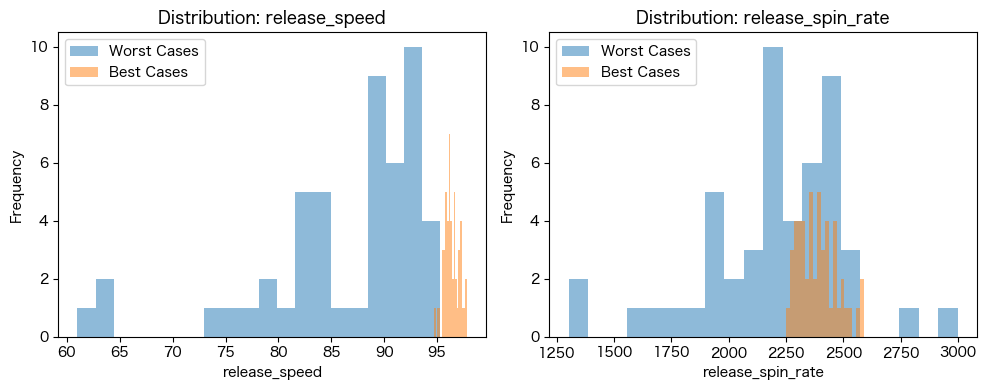

In [123]:
# Worst Casesの詳細データを表示
# 元のデータフレームから該当する行を取得
if 'X_fe_valid' in globals():
    # 検証データのインデックスを取得
    valid_indices = X_fe_valid.index if hasattr(X_fe_valid, 'index') else range(len(X_fe_valid))
    
    # Worst Casesの元データを取得
    worst_cases_data = []
    for case in worst_cases[:20]:  # 上位20件を表示
        idx = case['index']
        if isinstance(valid_indices, pd.Index):
            original_idx = valid_indices[idx]
        else:
            original_idx = idx
        
        # 元のデータから該当行を取得（可能な場合）
        if 'data' in globals() and original_idx < len(data):
            row_data = data.iloc[original_idx].to_dict()
            row_data['worst_case_index'] = idx
            row_data['true_label'] = case['true_label']
            row_data['pred_label'] = case['pred_label']
            row_data['pred_proba'] = case['pred_proba']
            row_data['loss'] = case['loss']
            worst_cases_data.append(row_data)
    
    if worst_cases_data:
        worst_cases_detail_df = pd.DataFrame(worst_cases_data)
        print("Worst Casesの詳細データ（上位20件）:")
        print(worst_cases_detail_df[['worst_case_index', 'true_label', 'pred_label', 'pred_proba', 'loss']].head(20))
        
        # 主要な特徴量の統計を表示
        if 'release_speed' in worst_cases_detail_df.columns:
            print("\nWorst Casesの主要特徴量の統計:")
            print(worst_cases_detail_df[['release_speed', 'release_spin_rate', 'pitch_type']].describe())
else:
    print("元のデータフレームにアクセスできません。")
    print("Worst Casesのインデックス:", worst_indices[:20])

# 失敗データの特徴量分布を可視化（成功データと比較）
if 'X_fe_valid' in globals() and len(worst_indices) > 0:
    # 成功データのインデックス（損失が小さい上位50件）
    best_indices = np.argsort(sample_losses)[:50]
    
    # X_fe_validがDataFrameかnumpy配列かを判定
    is_dataframe = hasattr(X_fe_valid, 'columns')
    
    # 主要な特徴量を選択
    if is_dataframe:
        # DataFrameの場合
        if 'release_speed' in X_fe_valid.columns and 'release_spin_rate' in X_fe_valid.columns:
            key_features = ['release_speed', 'release_spin_rate']
            feature_indices = [X_fe_valid.columns.get_loc(f) for f in key_features]
        else:
            key_features = X_fe_valid.columns[:2].tolist()
            feature_indices = list(range(len(key_features)))
    else:
        # numpy配列の場合
        # feature_cols_feが利用可能か確認
        if 'feature_cols_fe' in globals():
            try:
                speed_idx = feature_cols_fe.index('release_speed') if 'release_speed' in feature_cols_fe else 0
                spin_idx = feature_cols_fe.index('release_spin_rate') if 'release_spin_rate' in feature_cols_fe else 1
                key_features = ['release_speed', 'release_spin_rate']
                feature_indices = [speed_idx, spin_idx]
            except Exception:
                key_features = ['Feature 0', 'Feature 1']
                feature_indices = [0, 1]
        else:
            # 特徴量名が不明な場合は最初の2列を使用
            key_features = ['Feature 0', 'Feature 1']
            feature_indices = [0, 1]
    
    fig, axes = plt.subplots(1, len(key_features), figsize=(5*len(key_features), 4))
    if len(key_features) == 1:
        axes = [axes]
    
    for i, (feat, feat_idx) in enumerate(zip(key_features, feature_indices)):
        try:
            if is_dataframe:
                # DataFrameの場合
                worst_values = X_fe_valid.iloc[worst_indices[:50]][feat]
                best_values = X_fe_valid.iloc[best_indices[:50]][feat]
            else:
                # numpy配列の場合
                worst_values = X_fe_valid[worst_indices[:50], feat_idx]
                best_values = X_fe_valid[best_indices[:50], feat_idx]
            
            axes[i].hist(worst_values, alpha=0.5, label='Worst Cases', bins=20)
            axes[i].hist(best_values, alpha=0.5, label='Best Cases', bins=20)
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'Distribution: {feat}')
            axes[i].legend()
        except Exception as e:
            print(f"特徴量 {feat} の可視化でエラーが発生しました: {e}")
            axes[i].text(0.5, 0.5, f'Error: {feat}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("可視化に必要なデータが不足しています。")

### 7.3 要因を見る（Feature Analysis）

なぜモデルはその予測をしたのか、判断の根拠を探ります。

#### 7.3.1 Feature Importance（特徴量重要度）の詳細分析

既に可視化したFeature Importanceを、より詳細に分析します。

特徴量重要度の比較（上位20件）:
             feature  lgb_importance  xgb_importance  rfc_importance  \
0      release_speed            6406        0.143600        0.233721   
1      release_pos_z            6253        0.021994        0.012024   
2  release_spin_rate            5562        0.107182        0.108366   
3              pfx_x            4826        0.119853        0.160294   
4              pfx_z            4722        0.331651        0.320860   
5      release_pos_x            4559        0.030894        0.026937   
6          spin_axis            4327        0.055516        0.118186   
7           p_throws             214        0.189310        0.019611   

   avg_importance  
0     2135.459107  
1     2084.344673  
2     1854.071849  
3     1608.760049  
4     1574.217504  
5     1519.685944  
6     1442.391234  
7       71.402974  


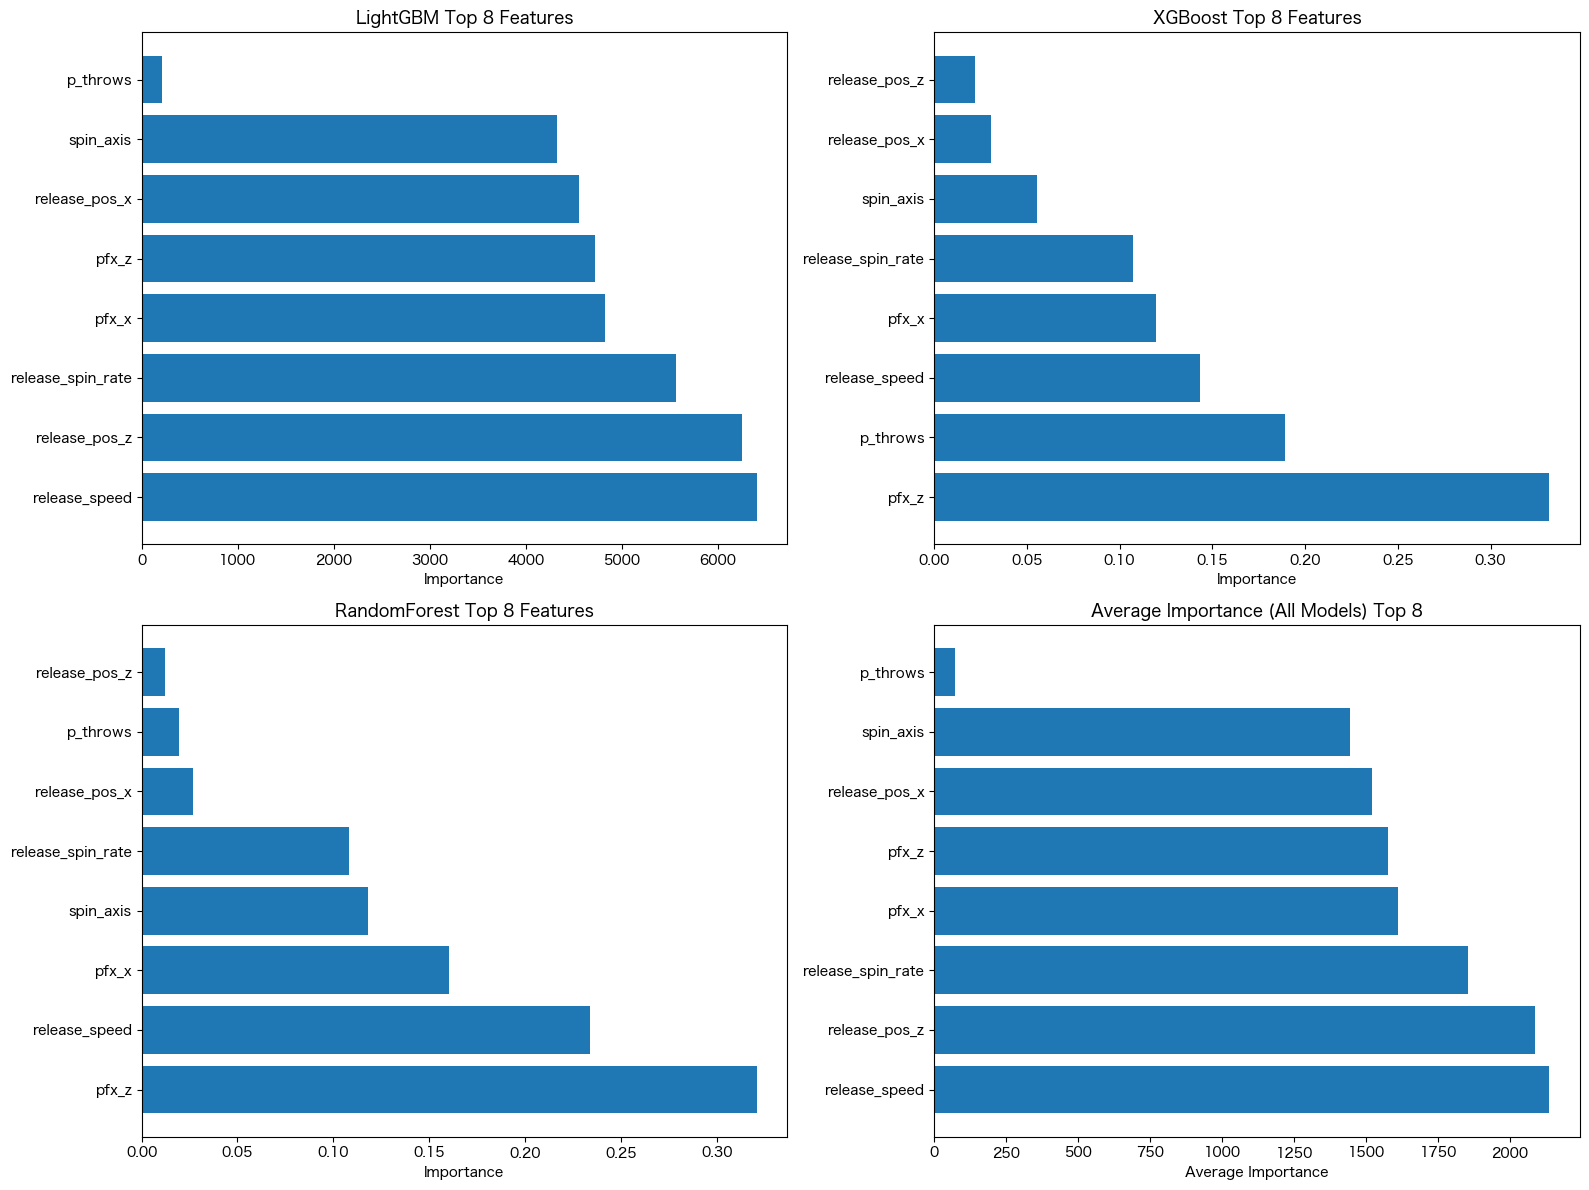


重要度が低い特徴量（下位10件）:
             feature  lgb_importance  xgb_importance  rfc_importance  \
0      release_speed            6406        0.143600        0.233721   
1      release_pos_z            6253        0.021994        0.012024   
2  release_spin_rate            5562        0.107182        0.108366   
3              pfx_x            4826        0.119853        0.160294   
4              pfx_z            4722        0.331651        0.320860   
5      release_pos_x            4559        0.030894        0.026937   
6          spin_axis            4327        0.055516        0.118186   
7           p_throws             214        0.189310        0.019611   

   avg_importance  
0     2135.459107  
1     2084.344673  
2     1854.071849  
3     1608.760049  
4     1574.217504  
5     1519.685944  
6     1442.391234  
7       71.402974  


In [124]:
# 各モデルの特徴量重要度を比較
lgb_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'lgb_importance': lgb_model.feature_importances_
}).sort_values('lgb_importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'xgb_importance': xgb_model.feature_importances_
}).sort_values('xgb_importance', ascending=False)

rfc_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'rfc_importance': rfc_fe.feature_importances_
}).sort_values('rfc_importance', ascending=False)

# マージして比較
importance_comparison = lgb_importance.merge(xgb_importance, on='feature').merge(rfc_importance, on='feature')
importance_comparison['avg_importance'] = (
    importance_comparison['lgb_importance'] + 
    importance_comparison['xgb_importance'] + 
    importance_comparison['rfc_importance']
) / 3
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("特徴量重要度の比較（上位20件）:")
print(importance_comparison.head(20))

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 各モデルの上位特徴量を取得（実際のデータ数に合わせる）
n_top = 15
lgb_top = lgb_importance.head(min(n_top, len(lgb_importance)))
xgb_top = xgb_importance.head(min(n_top, len(xgb_importance)))
rfc_top = rfc_importance.head(min(n_top, len(rfc_importance)))
avg_top = importance_comparison.head(min(n_top, len(importance_comparison)))

# LightGBM
n_lgb = len(lgb_top)
axes[0, 0].barh(range(n_lgb), lgb_top['lgb_importance'].values)
axes[0, 0].set_yticks(range(n_lgb))
axes[0, 0].set_yticklabels(lgb_top['feature'].values)
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title(f'LightGBM Top {n_lgb} Features')

# XGBoost
n_xgb = len(xgb_top)
axes[0, 1].barh(range(n_xgb), xgb_top['xgb_importance'].values)
axes[0, 1].set_yticks(range(n_xgb))
axes[0, 1].set_yticklabels(xgb_top['feature'].values)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title(f'XGBoost Top {n_xgb} Features')

# RandomForest
n_rfc = len(rfc_top)
axes[1, 0].barh(range(n_rfc), rfc_top['rfc_importance'].values)
axes[1, 0].set_yticks(range(n_rfc))
axes[1, 0].set_yticklabels(rfc_top['feature'].values)
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title(f'RandomForest Top {n_rfc} Features')

# 平均重要度
n_avg = len(avg_top)
axes[1, 1].barh(range(n_avg), avg_top['avg_importance'].values)
axes[1, 1].set_yticks(range(n_avg))
axes[1, 1].set_yticklabels(avg_top['feature'].values)
axes[1, 1].set_xlabel('Average Importance')
axes[1, 1].set_title(f'Average Importance (All Models) Top {n_avg}')

plt.tight_layout()
plt.show()

# 重要度が低い特徴量を確認（削除候補）
print("\n重要度が低い特徴量（下位10件）:")
print(importance_comparison.tail(10))

#### 7.3.2 SHAP値の分析（推奨）

Feature Importanceの上位互換的な分析手法です。「その特徴量が予測値をプラスに動かしたか、マイナスに動かしたか」まで分かります。

例：「球速」が高いほど、ある球種の予測確率が「上がる」という関係が見える。
これが直感（ドメイン知識）と反している場合、データ処理かモデルの学習にバグがある可能性があります。

**注意**: SHAPライブラリがインストールされていない場合は、`pip install shap` を実行してください。

shap_valuesの形状: (100, 8, 15)
shap_values_classの形状（クラス0）: (100, 8)

Summary plotを描画します...
shap_values_classの形状: (100, 8)
X_sampleの形状: (100, 8)


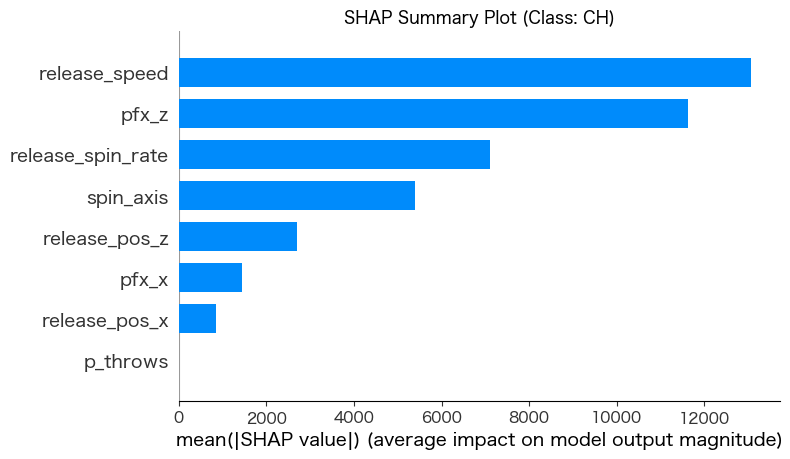

Summary plotを表示しました。

個別サンプルのSHAP値を可視化します...
（検証データからランダムに選ばれた個別の投球データのSHAP値を表示します）
X_sampleのサイズ: 100
クラス数: 15
shap_valuesの形状: (100, 8, 15)
y_fe_validの型: <class 'numpy.ndarray'>
y_fe_validの範囲: 0 - 14
sample_indices（最初の5つ）: [168874 151335 133477  85432  73984]

サンプル 0: original_idx=168874, true_class_idx=12, クラス名=SL
  shap_valuesの形状: (100, 8, 15)
  sample_shap_valuesの形状: (8,)
  sample_data_1dの形状: (8,)
  base_value: -20492.112229774455
  特徴量数: 8


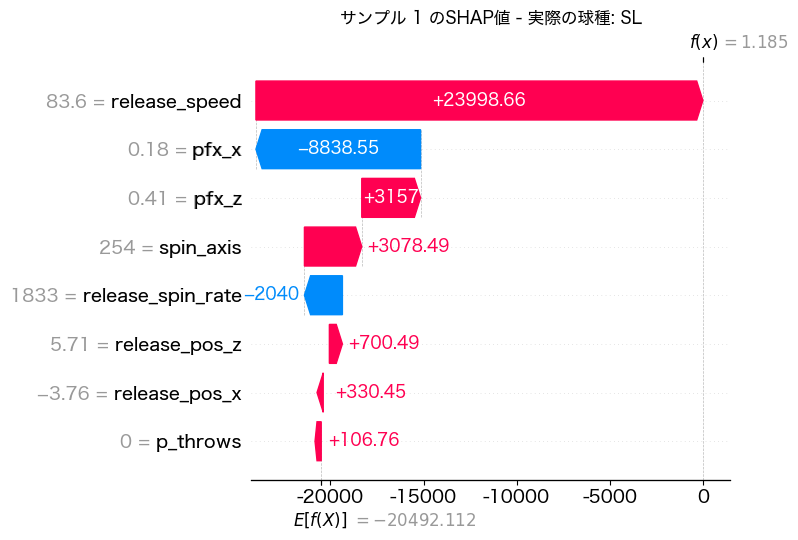

  サンプル 1/5 を表示しました（実際の球種: SL）

サンプル 1: original_idx=151335, true_class_idx=13, クラス名=ST
  shap_valuesの形状: (100, 8, 15)
  sample_shap_valuesの形状: (8,)
  sample_data_1dの形状: (8,)
  base_value: -6500.949537726353
  特徴量数: 8


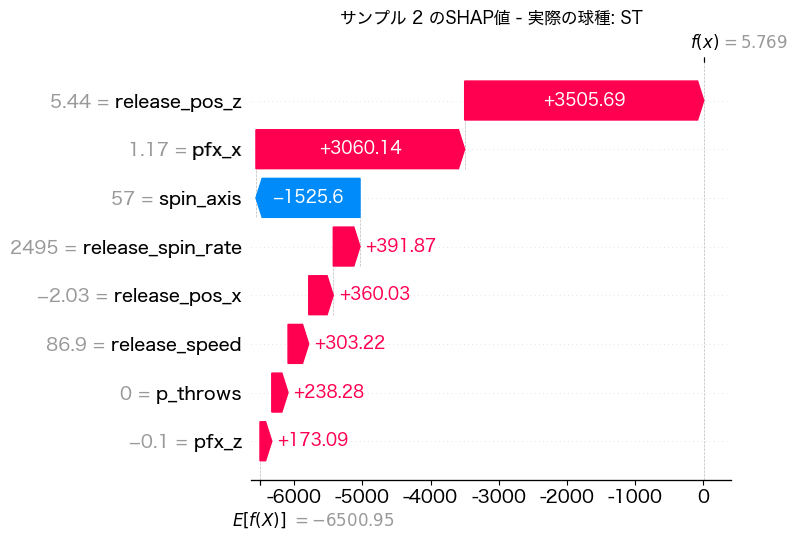

  サンプル 2/5 を表示しました（実際の球種: ST）

サンプル 2: original_idx=133477, true_class_idx=4, クラス名=FC
  shap_valuesの形状: (100, 8, 15)
  sample_shap_valuesの形状: (8,)
  sample_data_1dの形状: (8,)
  base_value: -26707.12335278223
  特徴量数: 8


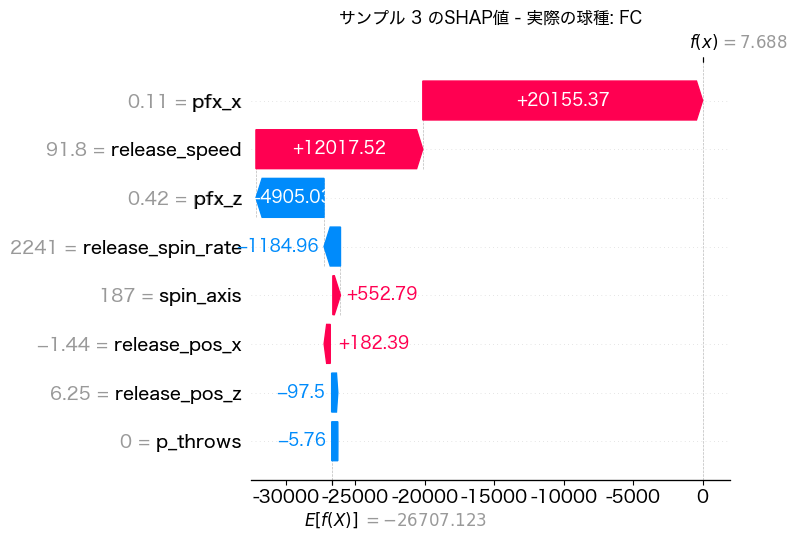

  サンプル 3/5 を表示しました（実際の球種: FC）

サンプル 3: original_idx=85432, true_class_idx=4, クラス名=FC
  shap_valuesの形状: (100, 8, 15)
  sample_shap_valuesの形状: (8,)
  sample_data_1dの形状: (8,)
  base_value: -26707.12335278223
  特徴量数: 8


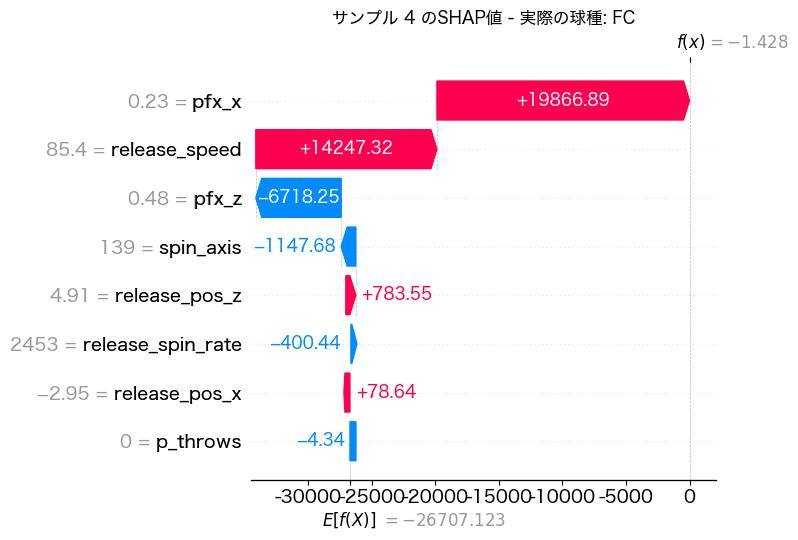

  サンプル 4/5 を表示しました（実際の球種: FC）

サンプル 4: original_idx=73984, true_class_idx=5, クラス名=FF
  shap_valuesの形状: (100, 8, 15)
  sample_shap_valuesの形状: (8,)
  sample_data_1dの形状: (8,)
  base_value: 5005.499111454388
  特徴量数: 8


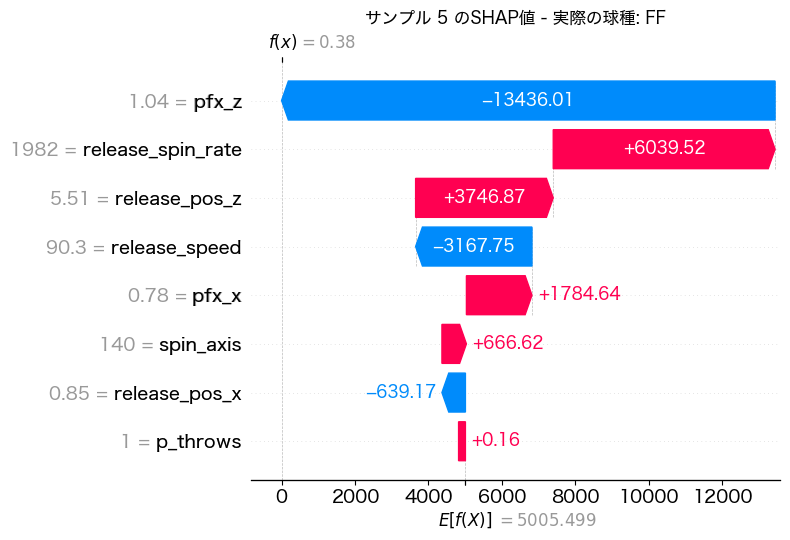

  サンプル 5/5 を表示しました（実際の球種: FF）

SHAP値の分析が完了しました。


In [125]:
# SHAP値の計算と可視化
try:
    import shap
    
    # SHAP値を計算（サンプル数を制限して計算時間を短縮）
    sample_size = min(100, len(X_fe_valid))
    sample_indices = np.random.choice(len(X_fe_valid), sample_size, replace=False)
    X_sample = X_fe_valid.iloc[sample_indices] if hasattr(X_fe_valid, 'iloc') else X_fe_valid[sample_indices]
    
    # LightGBMモデルでSHAP値を計算
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample)
    
    # 各クラスごとのSHAP値を可視化（最初のクラスのみ）
    # shap_valuesの形状に応じて適切に処理
    if isinstance(shap_values, list):
        # リスト形式: shap_values[クラス][サンプル, 特徴量]
        class_idx = 0
        shap_values_class = shap_values[class_idx]
    elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
        # 3次元配列形式: shap_values[サンプル, 特徴量, クラス] または shap_values[サンプル, クラス, 特徴量]
        print(f"shap_valuesの形状: {shap_values.shape}")
        
        # 形状から次元を判断
        if shap_values.shape[1] == len(class_names):
            # shap_values[サンプル, クラス, 特徴量] の形式
            shap_values_class = shap_values[:, 0, :]  # クラス0のSHAP値
        elif shap_values.shape[2] == len(class_names):
            # shap_values[サンプル, 特徴量, クラス] の形式
            shap_values_class = shap_values[:, :, 0]  # クラス0のSHAP値
        else:
            print(f"警告: shap_valuesの形状が予期しない形式です: {shap_values.shape}")
            shap_values_class = shap_values[:, :, 0]  # デフォルトとして試す
        
        print(f"shap_values_classの形状（クラス0）: {shap_values_class.shape}")
    else:
        # 2次元配列形式: shap_values[サンプル, 特徴量] (2クラス分類の場合)
        shap_values_class = shap_values
    
    # Summary plot（全体の傾向）
    # shap_values_classは(サンプル数, 特徴量数)の2次元配列である必要がある
    print("\nSummary plotを描画します...")
    print(f"shap_values_classの形状: {shap_values_class.shape if hasattr(shap_values_class, 'shape') else 'N/A'}")
    print(f"X_sampleの形状: {X_sample.shape if hasattr(X_sample, 'shape') else 'N/A'}")
    
    # 特徴量名を取得
    if 'feature_cols_fe' in globals():
        feature_names = feature_cols_fe
    elif hasattr(X_sample, 'columns'):
        feature_names = list(X_sample.columns)
    else:
        feature_names = [f'Feature {i}' for i in range(shap_values_class.shape[1])]
    
    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_class, X_sample, plot_type="bar", feature_names=feature_names, show=False)
        plt.title(f'SHAP Summary Plot (Class: {class_names[0]})')
        plt.tight_layout()
        plt.show()
        print("Summary plotを表示しました。")
    except Exception as e:
        print(f"Summary plotの描画でエラーが発生しました: {e}")
        print("代替として、特徴量重要度の棒グラフを表示します。")
        
        # 代替: 平均SHAP値の絶対値を計算して棒グラフで表示
        mean_shap = np.abs(shap_values_class).mean(axis=0)
        top_indices = np.argsort(mean_shap)[-15:][::-1]
        
        plt.figure(figsize=(10, 8))
        if 'feature_cols_fe' in globals():
            feat_names = [feature_cols_fe[idx] for idx in top_indices]
        elif hasattr(X_sample, 'columns'):
            feat_names = [X_sample.columns[idx] for idx in top_indices]
        else:
            feat_names = [f'Feature {idx}' for idx in top_indices]
        
        plt.barh(range(len(top_indices)), mean_shap[top_indices])
        plt.yticks(range(len(top_indices)), feat_names)
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'SHAP Summary (Class: {class_names[0]}) - Top 15 Features')
        plt.tight_layout()
        plt.show()
    
    # 個別サンプルのSHAP値を可視化（最初の5サンプル）
    # 各サンプルは検証データからランダムに選ばれた個別の投球データです
    print("\n個別サンプルのSHAP値を可視化します...")
    print("（検証データからランダムに選ばれた個別の投球データのSHAP値を表示します）")
    print(f"X_sampleのサイズ: {len(X_sample)}")
    print(f"クラス数: {len(class_names)}")
    if isinstance(shap_values, list):
        print(f"shap_valuesのリストサイズ: {len(shap_values)}")
        print(f"shap_valuesの形状（クラス0）: {shap_values[0].shape if hasattr(shap_values[0], 'shape') else 'N/A'}")
        # すべてのクラスの形状を確認
        for cls_idx in range(min(5, len(shap_values))):
            if hasattr(shap_values[cls_idx], 'shape'):
                print(f"  クラス {cls_idx} ({class_names[cls_idx]}): {shap_values[cls_idx].shape}")
    else:
        print(f"shap_valuesの形状: {shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")
    print(f"y_fe_validの型: {type(y_fe_valid)}")
    print(f"y_fe_validの範囲: {y_fe_valid.min()} - {y_fe_valid.max()}")
    print(f"sample_indices（最初の5つ）: {sample_indices[:5]}")
    
    for i in range(min(5, len(X_sample))):
        try:
            # サンプルのデータを取得（X_sample内のインデックスiを使用）
            sample_data = X_sample.iloc[i] if hasattr(X_sample, 'iloc') else X_sample[i]
            
            # 元のデータセットでの正解ラベルを取得
            original_idx = sample_indices[i]  # 元のデータセットでのインデックス
            
            # y_fe_validから正解ラベルのインデックスを取得
            # original_idxがy_fe_validの範囲内か確認
            if isinstance(y_fe_valid, np.ndarray):
                if original_idx >= len(y_fe_valid) or original_idx < 0:
                    print(f"  エラー: original_idx={original_idx}がy_fe_validの範囲外です（サイズ: {len(y_fe_valid)}）")
                    continue
                true_class_idx = int(y_fe_valid[original_idx])
            else:
                # DataFrameやSeriesの場合
                if original_idx >= len(y_fe_valid) or original_idx < 0:
                    print(f"  エラー: original_idx={original_idx}がy_fe_validの範囲外です（サイズ: {len(y_fe_valid)}）")
                    continue
                true_class_idx = int(y_fe_valid.iloc[original_idx])
            
            # デバッグ情報
            print(f"\nサンプル {i}: original_idx={original_idx}, true_class_idx={true_class_idx}", end="")
            if true_class_idx < len(class_names):
                print(f", クラス名={class_names[true_class_idx]}")
            else:
                print(" (範囲外!)")
            
            # true_class_idxが有効な範囲内か確認
            if true_class_idx >= len(class_names) or true_class_idx < 0:
                print(f"  エラー: true_class_idx={true_class_idx}が範囲外です（クラス数: {len(class_names)}）")
                continue
            
            # SHAP値を取得（1つのサンプル分のみ）
            # 注意: shap_valuesはX_sampleに対して計算されているので、インデックスiを使用
            
            # shap_valuesの形状を確認して適切にアクセス
            if isinstance(shap_values, list):
                # リスト形式: shap_values[クラス][サンプル, 特徴量]
                if true_class_idx >= len(shap_values):
                    print(f"  エラー: true_class_idx={true_class_idx}がshap_valuesの範囲外です（shap_valuesのサイズ: {len(shap_values)}）")
                    continue
                
                shap_values_for_class = shap_values[true_class_idx]
                if i >= shap_values_for_class.shape[0]:
                    print(f"  エラー: インデックス {i} が範囲外です。shap_values[{true_class_idx}]のサイズ: {shap_values_for_class.shape[0]}")
                    continue
                
                sample_shap_values = shap_values_for_class[i]  # サンプルiのSHAP値（1次元配列）
                base_value = explainer.expected_value[true_class_idx] if isinstance(explainer.expected_value, list) else explainer.expected_value
            elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
                # 3次元配列形式: shap_values[サンプル, 特徴量, クラス] または shap_values[サンプル, クラス, 特徴量]
                print(f"  shap_valuesの形状: {shap_values.shape}")
                
                # 形状から次元を判断: (サンプル数, 特徴量数, クラス数) または (サンプル数, クラス数, 特徴量数)
                if shap_values.shape[1] == len(class_names):
                    # shap_values[サンプル, クラス, 特徴量] の形式
                    sample_shap_values = shap_values[i, true_class_idx, :]  # サンプルi、クラスtrue_class_idxのSHAP値
                elif shap_values.shape[2] == len(class_names):
                    # shap_values[サンプル, 特徴量, クラス] の形式
                    sample_shap_values = shap_values[i, :, true_class_idx]  # サンプルi、クラスtrue_class_idxのSHAP値
                else:
                    print(f"  エラー: shap_valuesの形状が予期しない形式です: {shap_values.shape}")
                    continue
                
                # base_valueの取得
                if isinstance(explainer.expected_value, (list, np.ndarray)):
                    base_value = explainer.expected_value[true_class_idx]
                else:
                    base_value = explainer.expected_value
            else:
                # 2次元配列形式: shap_values[サンプル, 特徴量] (2クラス分類の場合)
                sample_shap_values = shap_values[i]  # サンプルiのSHAP値（1次元配列）
                base_value = explainer.expected_value if isinstance(explainer.expected_value, (int, float)) else explainer.expected_value[0]
            
            # サンプルのデータを1次元配列に変換
            if hasattr(sample_data, 'values'):
                sample_data_1d = sample_data.values
            elif hasattr(sample_data, 'flatten'):
                sample_data_1d = sample_data.flatten()
            else:
                sample_data_1d = np.array(sample_data).flatten()
            
            # SHAP値も1次元配列であることを確認
            sample_shap_values = np.array(sample_shap_values).flatten()
            
            # 特徴量名を取得
            if 'feature_cols_fe' in globals():
                feat_names = feature_cols_fe
            elif hasattr(X_sample, 'columns'):
                feat_names = list(X_sample.columns)
            else:
                feat_names = [f'Feature {j}' for j in range(len(sample_shap_values))]
            
            # デバッグ: データの形状を確認
            print(f"  sample_shap_valuesの形状: {sample_shap_values.shape}")
            print(f"  sample_data_1dの形状: {sample_data_1d.shape}")
            print(f"  base_value: {base_value}")
            print(f"  特徴量数: {len(feat_names)}")
            
            # Waterfall plotを描画（新しいAPIを試す）
            try:
                # SHAP 0.40以降の新しいAPI
                # 1つのサンプルのSHAP値のみを渡す
                # values, data, base_valuesの形状を確認
                if len(sample_shap_values) != len(sample_data_1d):
                    print(f"  エラー: sample_shap_valuesの長さ({len(sample_shap_values)})とsample_data_1dの長さ({len(sample_data_1d)})が一致しません")
                    raise ValueError("Shape mismatch")
                
                explanation = shap.Explanation(
                    values=sample_shap_values.reshape(1, -1),  # (1, 特徴量数)の形状に変換
                    base_values=np.array([base_value]),  # スカラー値を配列に変換
                    data=sample_data_1d.reshape(1, -1),  # (1, 特徴量数)の形状に変換
                    feature_names=feat_names
                )
                shap.plots.waterfall(explanation[0], show=False)  # 最初のサンプルのみ
            except (AttributeError, TypeError, ValueError, IndexError) as e:
                print(f"  waterfall plotでエラー: {e}")
                # 古いAPIまたはwaterfall_plotが使えない場合
                try:
                    shap.waterfall_plot(shap.Explanation(
                        values=sample_shap_values.reshape(1, -1),  # (1, 特徴量数)の形状に変換
                        base_values=np.array([base_value]),  # スカラー値を配列に変換
                        data=sample_data_1d.reshape(1, -1),  # (1, 特徴量数)の形状に変換
                        feature_names=feat_names
                    )[0], show=False)  # 最初のサンプルのみ
                except Exception:
                    # 代替としてbar plotを使用
                    plt.figure(figsize=(10, 6))
                    top_indices = np.argsort(np.abs(sample_shap_values))[-10:][::-1]
                    plt.barh(range(len(top_indices)), sample_shap_values[top_indices])
                    plt.yticks(range(len(top_indices)), [feat_names[idx] for idx in top_indices])
                    plt.xlabel('SHAP Value')
                    plt.title(f'サンプル {i+1} のSHAP値 (Top 10) - 実際の球種: {class_names[true_class_idx]}')
            
            plt.title(f'サンプル {i+1} のSHAP値 - 実際の球種: {class_names[true_class_idx]}')
            plt.tight_layout()
            plt.show()
            print(f"  サンプル {i+1}/5 を表示しました（実際の球種: {class_names[true_class_idx]}）")
        except Exception as e:
            print(f"サンプル {i} の可視化でエラーが発生しました: {e}")
            continue
    
    print("\nSHAP値の分析が完了しました。")
    
except ImportError:
    print("SHAPライブラリがインストールされていません。")
    print("インストールするには: pip install shap")
    print("\n代替として、部分依存プロット（Partial Dependence Plot）を表示します。")
    
    # 部分依存プロット（代替）
    from sklearn.inspection import PartialDependenceDisplay
    
    # X_fe_validがDataFrameかnumpy配列かを判定
    is_dataframe = hasattr(X_fe_valid, 'columns')
    
    # 主要な特徴量を選択
    top_features = importance_comparison.head(5)['feature'].tolist()
    
    # 特徴量のインデックスを取得
    feature_indices = []
    valid_features = []
    for feat in top_features:
        if is_dataframe:
            if feat in X_fe_valid.columns:
                feat_idx = list(X_fe_valid.columns).index(feat)
                feature_indices.append(feat_idx)
                valid_features.append(feat)
        else:
            # numpy配列の場合
            if 'feature_cols_fe' in globals() and feat in feature_cols_fe:
                feat_idx = feature_cols_fe.index(feat)
                feature_indices.append(feat_idx)
                valid_features.append(feat)
    
    if len(valid_features) == 0:
        print("可視化できる特徴量が見つかりませんでした。")
    else:
        fig, axes = plt.subplots(1, len(valid_features), figsize=(5*len(valid_features), 4))
        if len(valid_features) == 1:
            axes = [axes]
        
        for i, (feat, feat_idx) in enumerate(zip(valid_features, feature_indices)):
            try:
                # feature_namesは、numpy配列の場合は必須
                if is_dataframe:
                    display = PartialDependenceDisplay.from_estimator(
                        lgb_model, X_fe_valid, [feat_idx], 
                        ax=axes[i], feature_names=list(X_fe_valid.columns) if hasattr(X_fe_valid, 'columns') else None
                    )
                else:
                    # numpy配列の場合
                    if 'feature_cols_fe' in globals():
                        display = PartialDependenceDisplay.from_estimator(
                            lgb_model, X_fe_valid, [feat_idx], 
                            ax=axes[i], feature_names=feature_cols_fe
                        )
                    else:
                        display = PartialDependenceDisplay.from_estimator(
                            lgb_model, X_fe_valid, [feat_idx], 
                            ax=axes[i]
                        )
                axes[i].set_title(f'Partial Dependence: {feat}')
            except Exception as e:
                print(f"特徴量 {feat} の可視化でエラーが発生しました: {e}")
                axes[i].text(0.5, 0.5, f'Error: {feat}', ha='center', va='center')
        
        plt.tight_layout()
        plt.show()

### 7.4 分析結果のまとめと次の仮説

このフェーズを終えるとき、手元に以下の「次の仮説」が揃っている状態を目指してください。

#### チェックリスト

- [ ] **データの修正**: 「この外れ値データは学習に悪影響なので削除しよう」
- [ ] **特徴量の追加**: 「失敗データは〇〇という傾向があるから、それを数値化する新しい特徴量を作ろう」
- [ ] **モデルの変更**: 「このモデルは線形な関係を捉えられていないから、ニューラルネットも試そう」
- [ ] **前処理の変更**: 「外れ値に引っ張られているから、対数変換して分布を整えよう」

#### 次のステップ

1. 分析結果を基に、新しい特徴量を設計
2. 前処理方法を見直す
3. モデルのハイパーパラメータを調整
4. 新しいモデルを試す
5. Local CVで検証
6. 結果が改善したら、再度このError Analysisを実行

#### 7.2.3 Worst Casesの結果分析と解釈

Worst Casesの結果から、以下のようなパターンが見えてきます：

##### よく見られる誤分類パターン

1. **「Others」→「FF」の誤分類が多い**
   - 上位20件の多くがこのパターン
   - 予測確率が非常に高い（0.97以上）のに間違っている
   - **仮説**: 「Others」クラスが多様すぎて、モデルが「FF」と混同しやすい可能性

2. **「KN」「SL」「FA」→「FF」の誤分類**
   - いくつかの球種が「FF」と誤分類されている
   - **仮説**: 球速や回転数がFFに近い特徴を持つ投球が存在する可能性

3. **予測確率が高いのに間違っている（過信）**
   - モデルが「99% FFだ」と確信しているのに、実際は違う
   - **仮説**: キャリブレーションの問題（確率と実際の正解率が合っていない）

##### 次のステップのヒント

- **「Others」クラスの分析**: このクラスに含まれる投球の特徴を詳しく調べる
  - 本当に「Others」なのか、それとも他の球種に分類すべきか？
  - 「Others」をさらに細分化できるか？

- **特徴量の追加**: 誤分類が多い組み合わせに共通する特徴量がないか調べる
  - 投手ID、球場、カウントなどの文脈情報
  - 投球の軌道や変化量の詳細な特徴

- **キャリブレーションの改善**: 予測確率をより信頼できるようにする
  - キャリブレーション曲線（7.1.3）で確認
  - Platt scalingやIsotonic regressionなどの手法を検討

誤分類パターンの集計（上位20件）:

誤分類の組み合わせ（多い順）:
true_label pred_label  count
    Others         FF     11
        FA         FF      4
        FA         CH      1
        FA         SI      1
        KC         CH      1
        KN         CH      1
    Others         CU      1

正解ラベルごとの誤分類先:

正解: Others
  誤分類先: {'FF': 11, 'CU': 1}

正解: FA
  誤分類先: {'FF': 4, 'SI': 1, 'CH': 1}

正解: KC
  誤分類先: {'CH': 1}

正解: KN
  誤分類先: {'CH': 1}

予測確率の統計:
平均予測確率: 0.823
最大予測確率: 0.980
最小予測確率: 0.431

予測確率が0.9以上: 9件
予測確率が0.8以上: 14件

→ 予測確率が高いのに間違っている = モデルが過信している可能性


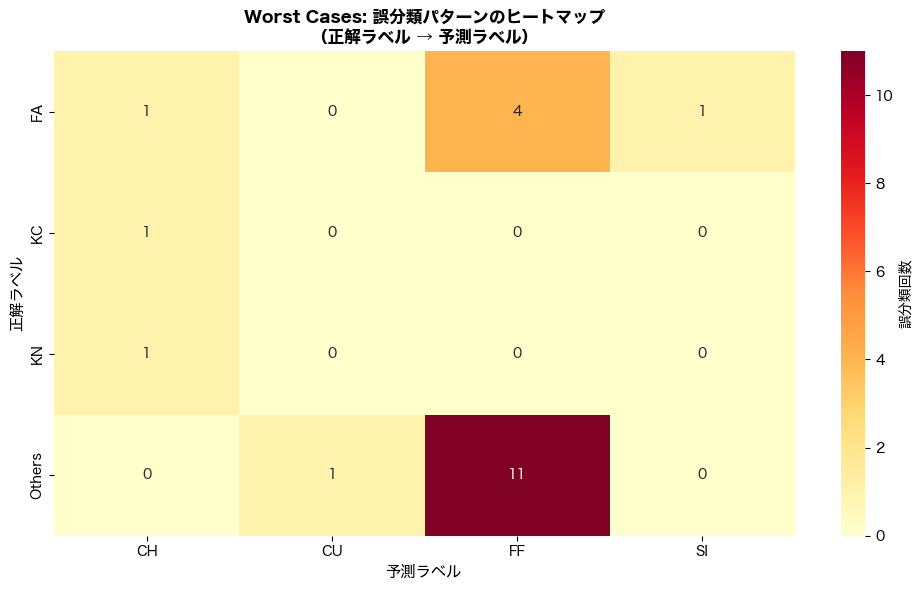

In [126]:
# Worst Casesのパターン分析
if 'worst_cases_detail_df' in locals() or 'worst_cases_detail_df' in globals():
    worst_df = worst_cases_detail_df.copy()
    
    # 誤分類パターンの集計
    print("="*60)
    print("誤分類パターンの集計（上位20件）:")
    print("="*60)
    
    # 正解ラベル → 予測ラベルの組み合わせを集計
    confusion_patterns = worst_df.groupby(['true_label', 'pred_label']).size().reset_index(name='count')
    confusion_patterns = confusion_patterns.sort_values('count', ascending=False)
    print("\n誤分類の組み合わせ（多い順）:")
    print(confusion_patterns.to_string(index=False))
    
    # 各正解ラベルごとの誤分類先を集計
    print("\n" + "="*60)
    print("正解ラベルごとの誤分類先:")
    print("="*60)
    for true_label in worst_df['true_label'].unique():
        subset = worst_df[worst_df['true_label'] == true_label]
        pred_counts = subset['pred_label'].value_counts()
        print(f"\n正解: {true_label}")
        print(f"  誤分類先: {pred_counts.to_dict()}")
    
    # 予測確率の分布を確認
    print("\n" + "="*60)
    print("予測確率の統計:")
    print("="*60)
    print(f"平均予測確率: {worst_df['pred_proba'].mean():.3f}")
    print(f"最大予測確率: {worst_df['pred_proba'].max():.3f}")
    print(f"最小予測確率: {worst_df['pred_proba'].min():.3f}")
    print(f"\n予測確率が0.9以上: {(worst_df['pred_proba'] >= 0.9).sum()}件")
    print(f"予測確率が0.8以上: {(worst_df['pred_proba'] >= 0.8).sum()}件")
    print("\n→ 予測確率が高いのに間違っている = モデルが過信している可能性")
    
    # 可視化: 誤分類パターンのヒートマップ
    if len(confusion_patterns) > 0:
        pivot_table = confusion_patterns.pivot(index='true_label', columns='pred_label', values='count')
        pivot_table = pivot_table.fillna(0)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', 
                    cbar_kws={'label': '誤分類回数'})
        plt.title('Worst Cases: 誤分類パターンのヒートマップ\n（正解ラベル → 予測ラベル）', fontsize=12, fontweight='bold')
        plt.xlabel('予測ラベル', fontsize=11)
        plt.ylabel('正解ラベル', fontsize=11)
        plt.tight_layout()
        plt.show()
        
else:
    print("Worst Casesの詳細データが利用できません。")
    print("先に7.2.1のWorst Cases抽出を実行してください。")